# Instalações

In [ ]:
!pip install MySql
!pip install pyspark
!pip install 'apache-beam[gcp]'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 6.7 MB/s 
  Created wheel for mysqlclient: filename=mysqlclient-2.1.0-cp37-cp37m-linux_x86_64.whl size=99976 sha256=180ec550fb8a44a240fb3f0f77e62a6164b34d7aab17561b205799e176871eee
  Stored in directory: /root/.cache/pip/wheels/97/d4/df/08cd6e1fa4a8691b268ab254bd0fa589827ab5b65638c010b4
Successfully built mysqlclient
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 47 kB/s 
     |████████████████████████████████| 199 kB 52.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=882bd188febfd2985a442bc06b38422ee7055219a0290719af479c41826f41fa
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https:/

In [ ]:
!pip uninstall pymongo

Found existing installation: pymongo 3.12.3
Uninstalling pymongo-3.12.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/bson/*
    /usr/local/lib/python3.7/dist-packages/gridfs/*
    /usr/local/lib/python3.7/dist-packages/pymongo-3.12.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/pymongo/*
Proceed (y/n)? y
  Successfully uninstalled pymongo-3.12.3


In [ ]:
!pip install pymongo
!pip install dnspython
!pip install apache-beam[interactive]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 463 kB 27.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.39.0 requires pymongo<4.0.0,>=3.8.0, but you have pymongo 4.1.1 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 269 kB 24.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pymongo-3.12.3-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (508 kB)
     |████████████████████████████████| 793 kB 30.3 MB/s 
     |████████████████████████████████| 112 kB 62.6 MB/s 
     |████████████████████████████████| 133 kB 67.8 MB/s 
     |████████████████████████████████| 

# Importações

In [ ]:
import MySQLdb
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkConf
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import regexp_replace, col
import numpy as np
from google.colab import auth
from pymongo import MongoClient
import apache_beam as beam
import os
from apache_beam.options.pipeline_options import PipelineOptions
import csv
import time
from google.cloud import pubsub_v1
import os
from apache_beam import window
import psycopg2

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


# Inserindo/Extraindo dados iniciais - MySQL

A utilização do MySQL foi substituída, o banco SQL utilizado no lugar dele foi o Postgres cuja a seção está abaixo.

Inserindo os valores contidos no arquivo consumo de energia por setor

In [ ]:
try:
  con = MySQLdb.connect(host="", user="", passwd="", db="")
  con.select_db('datasets')
  cursor = con.cursor()

  dados = pd.read_csv('/content/consumo_energia_por_setor.csv', sep=';')

  for i, row in dados.iterrows():
        cursor.execute(f"INSERT INTO consumo_energia_por_setor (Data, TipoConsumidor, Sistema, UF, SetorN1, SetorN2, TensaoN1, TensaoN2, TensaoN3, FaixaDeConsumoN1, FaixaDeConsumoN2, Consumo, Consumidores) VALUES ('{row.Data}', '{row.TipoConsumidor}', '{row.Sistema}', '{row.UF}', '{row.SetorN1}', '{row.SetorN2}', '{row.TensaoN1}', '{row.TensaoN2}', '{row.TensaoN3}', '{row.FaixaDeConsumoN1}', '{row.FaixaDeConsumoN2}', '{row.Consumo}', '{row.Consumidores}')")
        print(f'Linha {i} inserida!')
        con.commit()
except Exception as e:
  print(str(e))

[Errno 2] No such file or directory: '/content/consumo_energia_por_setor.csv'


Processo de extração de dados

In [ ]:
try:
  con = MySQLdb.connect(host="", user="", passwd="", db="")
  con.select_db('')
  cursor = con.cursor()

  try:
      cursor.execute("SELECT * FROM consumo_energia_por_setor")
      dados = cursor.fetchall()
      cursor.close()
      lista_dados = []
      for dado in dados:
        lista_dados.append(dado)
  except Exception as e:
      print(str(e))

  df_inicial = pd.DataFrame(lista_dados)
  df_inicial
except Exception as e:
  print(str(e))

Inserindo os valores contidos no arquivo geração por fonte

In [ ]:
try:
  con = MySQLdb.connect(host="", user="", passwd="", db="")
  con.select_db('')
  cursor = con.cursor()

  dados = pd.read_csv('/content/Geracao_por_fonte.csv', sep=';')

  for i, row in dados.iterrows():
      try:
          cursor.execute(f"INSERT INTO geracao_por_fonte (id_geracao_fonte, nome_fonte_geracao, media_energia_despachada_gigawatt_hora, mes_referencia, ano_referencia, data_processamento) VALUES ('{row.ideGeracaoFonte}', '{row.nomFonteGeracao}', '{row.mdaEnergiaDespachadaGWh}', '{row.mesReferencia}', '{row.anoReferencia}', '{row.dthProcessamento}')")
          print(f'Linha {i} inserida!')
          con.commit()
      except Exception as e:
          print(str(e))
          continue
except Exception as e:
  print(str(e))

Processo de extração de dados

In [ ]:
try:
  con = MySQLdb.connect(host="", user="", passwd="", db="")
  con.select_db('')
  cursor = con.cursor()

  try:
      cursor.execute("SELECT * FROM geracao_por_fonte")
      dados = cursor.fetchall()
      cursor.close()
      lista_dados_geracao = []
      for dado in dados:
        lista_dados_geracao.append(dado)
  except Exception as e:
      print(str(e))

  df_inicial_geracao_fonte = pd.DataFrame(lista_dados_geracao)
  df_inicial_geracao_fonte
except Exception as e:
  print(str(e))

# Extraindo dados do Postgres

Processo de extração de dados da tabela consumo_energia_por_setor

In [ ]:
conn = psycopg2.connect(host='', database='', user='', password='')
cursor = conn.cursor()

In [ ]:
cursor.execute("SELECT * FROM consumo_energia_por_setor")
dados = cursor.fetchall()
lista_dados = []
for dado in dados:
  lista_dados.append(dado)

In [ ]:
df_inicial = pd.DataFrame(lista_dados)

In [ ]:
df_inicial

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2,01/01/2013,Cativo,Nordeste,AL,Comercial,Comercial N2,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,27764,896
1,3,01/01/2013,Cativo,Nordeste,AL,Comercial,Comercial N2,B - Baixa Tensão,TOTAL,TOTAL,Não aplicável,Não aplicável,24381,51071
2,4,01/01/2013,Cativo,Nordeste,AL,Comercial,Outros Serviços e Atividades,B - Baixa Tensão,TOTAL,TOTAL,Não aplicável,Não aplicável,231,877
3,5,01/01/2013,Cativo,Nordeste,AL,Comercial,Serviços de Comunicações e Telecomunicações,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,245,27
4,6,01/01/2013,Cativo,Nordeste,AL,Comercial,Serviços de Comunicações e Telecomunicações,B - Baixa Tensão,TOTAL,TOTAL,Não aplicável,Não aplicável,2644,2838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163672,163674,01/12/2019,Livre,Sul,SC,Industrial,TOTAL,A - Alta Tensão,A-3 - 69 kV,TOTAL,Não aplicável,Não aplicável,"62525,972",16
163673,163675,01/12/2019,Livre,Sul,SC,Industrial,TOTAL,A - Alta Tensão,A-3a - 30 a 44 kV,TOTAL,Não aplicável,Não aplicável,"6538,496",3
163674,163676,01/12/2019,Livre,Sul,SC,Industrial,TOTAL,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,"278507,489",625
163675,163677,01/12/2019,Livre,Sul,SC,Rural,Agroindústria,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,"4842,471",7


Processo de extração de dados da tabela geracao_por_fonte

In [ ]:
cursor.execute("SELECT * FROM geracao_por_fonte")
dados = cursor.fetchall()
cursor.close()
lista_dados_geracao = []
for dado in dados:
  lista_dados_geracao.append(dado)

In [ ]:
df_inicial_geracao_fonte = pd.DataFrame(lista_dados_geracao)

In [ ]:
df_inicial_geracao_fonte

,0,1,2,3,4,5
0,1,Hidreletricas exclusive Itaipu,"2,11E+14",1,2000,None
1,2,Itaipu,"6,52E+13",1,2000,None
2,3,Oleo Diesel / Combustivel,"1,12E+12",1,2000,None
3,4,Gas Natural,"5,13E+12",1,2000,None
4,5,Carvao,"7,73E+12",1,2000,None
...,...,...,...,...,...,...
2491,2492,Carvao,"6,11E+12",6,2020,16/11/2020 00:00
2492,2493,Biomassas,"1,03E+13",6,2020,16/11/2020 00:00
2493,2494,Nuclear,"1,04E+13",6,2020,16/11/2020 00:00
2494,2495,Residuos Processos Industriais,"7,66E+12",6,2020,16/11/2020 00:00


# Análise - PySpark - Consumo Energia

In [ ]:
spark = SparkSession.builder\
        .master('local')\
        .appName('projeto_final')\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
df_spark = spark.createDataFrame(df_inicial)

22/06/15 20:59:37 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [ ]:
spark

In [ ]:
df_spark = df_spark\
  .withColumnRenamed('0', 'id')\
  .withColumnRenamed('1', 'Data')\
  .withColumnRenamed('2', 'TipoConsumidor')\
  .withColumnRenamed('3','Sistema')\
  .withColumnRenamed('4','UF')\
  .withColumnRenamed('5','SetorN1')\
  .withColumnRenamed('6','SetorN2')\
  .withColumnRenamed('7','TensaoN1')\
  .withColumnRenamed('8','TensaoN2')\
  .withColumnRenamed('9','TensaoN3')\
  .withColumnRenamed('10','FaixaDeConsumoN1')\
  .withColumnRenamed('11','FaixaDeConsumoN2')\
  .withColumnRenamed('12','Consumo')\
  .withColumnRenamed('13','Consumidores')

## 1. Verificando valores únicos

**Métodos utilizados:**

1. ***select***: seleciona todos os dados do dataframe;
2. ***distinct***: os dados retornados serão diferentes uns dos outros;
3. ***show***: mostra todos os dados que foram filtrados com o distinct no select;
4. ***df.count***: retorna todos os valores, para que não se visualize apenas 20 ou que seja necessário especificar um valor;

```
df.select().distinct().show(df.count())
```

Observações:
1. *Coluna Data:*
  - Data mais antiga: 01/01/2013
  - Data mais recente: 01/12/2019
  - Todos os valores tem o seguinte formato: 01/mm/yyyy
  - Final: nenhuma inconsistência
2. *Coluna TipoConsumidor:*
  - Final: nenhuma inconsistência
3. *Coluna Sistema:*
  - Final: nenhuma inconsistência
4. *Coluna UF:*
  - Final: nenhuma inconsistência
5. *Coluna SetorN1:*
  - Final: nenhuma inconsistência
6. *Coluna SetorN2:*
  - Observações: Comercial N2 (sem inconsistência), TOTAL (possíveis inconsistências encontradas)
7. *Coluna TensaoN1:*
  - Final: nenhuma inconsistência
8. *Coluna TensaoN2:*
  - Observações: TOTAL (força por unidade de área transmitida na direção normal através do plano), B-4 (iluminação pública)
9. *Coluna TensaoN3:*
  - Observações: TOTAL (força por unidade de área transmitida na direção normal através do plano)
10. *Coluna FaixaDeConsumoN1:*
  - Final: nenhuma inconsistência
11. *Coluna FaixaDeConsumoN2:*
  - Final: nenhuma inconsistência
12. *Coluna Consumo:*
  - Observações: valores negativos, substituir , por ., transformar para float
13. *Coluna Consumidores:*
  - Observações: valores negativos, valores com vírgula [devem ser inteiros]


In [ ]:
lista_colunas_spark_consumo = ['Data', 'TipoConsumidor', 'Sistema', 'UF', 'SetorN1', 'SetorN2', 'TensaoN1', 'TensaoN2', 'TensaoN3', 'FaixaDeConsumoN1', 'FaixaDeConsumoN2', 'Consumo', 'Consumidores']

In [ ]:
try:
  for i in lista_colunas_spark_consumo:
    df_spark.select(f'{i}').distinct().orderBy(f'{i}').show(df_spark.count(), truncate=False)
    input("Digite uma tecla para prosseguir: ")
except Exception as e:
  print(str(e))

A saída de streaming foi truncada nas últimas 5000 linhas.
|841,601    |
|841,931    |
|8410       |
|84103      |
|84105      |
|84112      |
|84119      |
|8412       |
|8412,889   |
|84126,075  |
|8413       |
|84134      |
|8414       |
|8415       |
|8415,93    |
|84157      |
|8416,566   |
|8416,658   |
|84166      |
|84168      |
|8417       |
|8417,611   |
|8418       |
|8418,26    |
|841814     |
|84183      |
|84188,859  |
|8419       |
|8419,014   |
|84199,022  |
|842        |
|842,117    |
|842,393    |
|842,396    |
|842,61     |
|84208      |
|8421       |
|8421,118   |
|8421,583   |
|84211,531  |
|84216      |
|84218      |
|8422       |
|8422,914   |
|8422,971   |
|84222      |
|8423       |
|8424       |
|8424,384   |
|8424,984   |
|84241      |
|842416     |
|8425       |
|8425,153   |
|84252,775  |
|84254,286  |
|8426       |
|84263      |
|84265      |
|84269      |
|8427       |
|8428       |
|84285,181  |
|8429       |
|84292      |
|843        |
|843,133    |
|84

KeyboardInterrupt: ignored

## 2. Verificando nulos

**Métodos utilizados:**
1. ***select***: seleciona todos os dados do meu dataframe;
2. ***filter***: filtra os valores que representam o(s) parâmetros passados. Em conjunto com o is NULL, me retorna somente os valores nulos;
3. ***orderBy***: ordena os valores de acordo com o parâmetro;
4. ***show***: mostra todos os dados que foram filtrados com o distinct no filter;
```
df.select().filter().orderBy().show()
```

- Nenhum valor nulo encontrado


In [ ]:
try:
  for i in lista_colunas_spark_consumo:
    df_spark.select(f'{i}').filter(f'{i} is NULL').orderBy(f'{i}').show()
    #input("Digite uma tecla para prosseguir: ")
    print()
except Exception as e:
  print(str(e))

22/06/15 21:00:03 WARN TaskSetManager: Stage 78 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+----+
|Data|
+----+
+----+


22/06/15 21:00:03 WARN TaskSetManager: Stage 79 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+--------------+
|TipoConsumidor|
+--------------+
+--------------+


22/06/15 21:00:03 WARN TaskSetManager: Stage 80 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+-------+
|Sistema|
+-------+
+-------+


22/06/15 21:00:04 WARN TaskSetManager: Stage 81 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+
| UF|
+---+
+---+


22/06/15 21:00:04 WARN TaskSetManager: Stage 82 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+-------+
|SetorN1|
+-------+
+-------+


22/06/15 21:00:04 WARN TaskSetManager: Stage 83 contains a task of very lar

## 3. Verificando strings vazias

**Métodos utilizados:**

1. ***wher***e: utilizado para identificar se há um valor e se houver, onde ele está na minha coluna especifiada;
2. ***show***: mostra todos os dados que foram identificados utilizando o where;

```
df.where(df.coluna == '').show()
```

- Nenhuma String vazia;

In [ ]:
df_spark.where(df_spark.Data == '').show()

22/06/15 21:00:07 WARN TaskSetManager: Stage 91 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.TipoConsumidor == '').show()

22/06/15 21:00:08 WARN TaskSetManager: Stage 92 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.Sistema == '').show()

22/06/15 21:00:08 WARN TaskSetManager: Stage 93 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.UF == '').show()

22/06/15 21:00:09 WARN TaskSetManager: Stage 94 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.SetorN1 == '').show()

22/06/15 21:00:09 WARN TaskSetManager: Stage 95 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.SetorN2 == '').show()

22/06/15 21:00:09 WARN TaskSetManager: Stage 96 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.TensaoN1 == '').show()

22/06/15 21:00:10 WARN TaskSetManager: Stage 97 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.TensaoN2 == '').show()

22/06/15 21:00:10 WARN TaskSetManager: Stage 98 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.TensaoN3 == '').show()

22/06/15 21:00:11 WARN TaskSetManager: Stage 99 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.FaixaDeConsumoN1 == '').show()

22/06/15 21:00:11 WARN TaskSetManager: Stage 100 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.FaixaDeConsumoN2 == '').show()

22/06/15 21:00:11 WARN TaskSetManager: Stage 101 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.Consumo == '').show()

22/06/15 21:00:12 WARN TaskSetManager: Stage 102 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.where(df_spark.Consumidores == '').show()

22/06/15 21:00:12 WARN TaskSetManager: Stage 103 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



## 4. Verificando caracteres especiais

Utilizando funções nativas do Python e funções do PySpark para a verificação de caracteres especiais que podem ser considerados como inconsistências. Utilização de laço de repetição para que o processo ocorra de maneira fluida.

**Métodos utilizados:**
1. ***select:*** seleciona uma coluna específica;
2. ***filter:*** filtra os dados;
3. ***show:*** retorna os dados que foram filtrados;



```
df.select().filter().show()
```



- Inconsistências encontradas: coluna consumo e consumidores com valores negativos;


In [ ]:
try:
  verificacao_caractere_spark = str(input('Insira o valor que você deseja verificar: '))
  for i in lista_colunas_spark_consumo:
    df_spark.select(f'{i}').filter(f"{i} like '%{verificacao_caractere_spark}%'").show()
except Exception as e:
  print(str(e))

Insira o valor que você deseja verificar: :
22/06/15 21:00:24 WARN TaskSetManager: Stage 104 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+----+
|Data|
+----+
+----+

22/06/15 21:00:24 WARN TaskSetManager: Stage 105 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+--------------+
|TipoConsumidor|
+--------------+
+--------------+

22/06/15 21:00:24 WARN TaskSetManager: Stage 106 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+-------+
|Sistema|
+-------+
+-------+

22/06/15 21:00:25 WARN TaskSetManager: Stage 107 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+---+
| UF|
+---+
+---+

22/06/15 21:00:25 WARN TaskSetManager: Stage 108 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+-------+
|SetorN1|
+-------+
+-------+

22/06/15 21:00:25 WARN TaskSetM

In [ ]:
df_spark.filter("Consumidores like '-1'").show()

22/06/15 21:00:28 WARN TaskSetManager: Stage 117 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+------+----------+--------------+--------------------+---+------------------+------------------+----------------+-----------------+--------------------+----------------+----------------+-------+------------+
|    id|      Data|TipoConsumidor|             Sistema| UF|           SetorN1|           SetorN2|        TensaoN1|         TensaoN2|            TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+------+----------+--------------+--------------------+---+------------------+------------------+----------------+-----------------+--------------------+----------------+----------------+-------+------------+
| 11799|01/07/2013|        Cativo|   Sistemas Isolados| PA|         Comercial|Templos Religiosos| A - Alta Tensão|A-4 - 2,3 a 25 kV|               TOTAL|   Não aplicável|   Não aplicável|     -1|          -1|
|121796|01/02/2018| 

In [ ]:
df_spark.filter("Consumidores like '-10'").show()

22/06/15 21:00:28 WARN TaskSetManager: Stage 118 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+-----+----------+--------------+--------------------+---+-------+------------+---------------+-----------------+--------+----------------+----------------+-------+------------+
|   id|      Data|TipoConsumidor|             Sistema| UF|SetorN1|     SetorN2|       TensaoN1|         TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+-----+----------+--------------+--------------------+---+-------+------------+---------------+-----------------+--------+----------------+----------------+-------+------------+
|14380|01/08/2013|        Cativo|Sudeste / Centro-...| SP|  Rural|Agropecuária|A - Alta Tensão|A-3a - 30 a 44 kV|   TOTAL|   Não aplicável|   Não aplicável|    582|         -10|
+-----+----------+--------------+--------------------+---+-------+------------+---------------+-----------------+--------+----------------+-----

In [ ]:
df_spark.filter("Consumidores like '-14'").show()

22/06/15 21:00:29 WARN TaskSetManager: Stage 119 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+-----+----------+--------------+--------------------+---+-------+------------+---------------+-----------------+--------+----------------+----------------+-------+------------+
|   id|      Data|TipoConsumidor|             Sistema| UF|SetorN1|     SetorN2|       TensaoN1|         TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+-----+----------+--------------+--------------------+---+-------+------------+---------------+-----------------+--------+----------------+----------------+-------+------------+
|16250|01/09/2013|        Cativo|Sudeste / Centro-...| SP|  Rural|Agropecuária|A - Alta Tensão|A-3a - 30 a 44 kV|   TOTAL|   Não aplicável|   Não aplicável|   3491|         -14|
+-----+----------+--------------+--------------------+---+-------+------------+---------------+-----------------+--------+----------------+-----

In [ ]:
df_spark.filter("Consumidores like '-6'").show()

22/06/15 21:00:29 WARN TaskSetManager: Stage 120 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+-----+----------+--------------+--------------------+---+----------+-----------+---------------+-----------------+--------+----------------+----------------+-------+------------+
|   id|      Data|TipoConsumidor|             Sistema| UF|   SetorN1|    SetorN2|       TensaoN1|         TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+-----+----------+--------------+--------------------+---+----------+-----------+---------------+-----------------+--------+----------------+----------------+-------+------------+
|28953|01/04/2014|        Cativo|Sudeste / Centro-...| ES|     Rural|Aquicultura|A - Alta Tensão|A-4 - 2,3 a 25 kV|   TOTAL|   Não aplicável|   Não aplicável|    -84|          -6|
|79394|01/07/2016|        Cativo|            Nordeste| PI|Industrial|      TOTAL|A - Alta Tensão|      A-3 - 69 kV|   TOTAL|   Não aplic

In [ ]:
df_spark.filter("Consumidores like '-4'").show()

22/06/15 21:00:30 WARN TaskSetManager: Stage 121 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+-----+----------+--------------+-----------------+---+---------------+---------------+----------------+--------+--------+----------------+----------------+-------+------------+
|   id|      Data|TipoConsumidor|          Sistema| UF|        SetorN1|        SetorN2|        TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+-----+----------+--------------+-----------------+---+---------------+---------------+----------------+--------+--------+----------------+----------------+-------+------------+
|68474|01/01/2016|        Cativo|Sistemas Isolados| RO|Serviço Público|Tração Elétrica|B - Baixa Tensão|   TOTAL|   TOTAL|   Não aplicável|   Não aplicável|     -7|          -4|
+-----+----------+--------------+-----------------+---+---------------+---------------+----------------+--------+--------+----------------+-----

In [ ]:
df_spark.filter("Consumidores like '-2'").show()

22/06/15 21:00:30 WARN TaskSetManager: Stage 122 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+------+----------+--------------+--------------------+---+---------------+--------------------+---------------+-----------------+--------+----------------+----------------+-------+------------+
|    id|      Data|TipoConsumidor|             Sistema| UF|        SetorN1|             SetorN2|       TensaoN1|         TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+------+----------+--------------+--------------------+---+---------------+--------------------+---------------+-----------------+--------+----------------+----------------+-------+------------+
| 70901|01/02/2016|        Cativo|Sudeste / Centro-...| RO|     Industrial|               TOTAL|A - Alta Tensão|      A-3 - 69 kV|   TOTAL|   Não aplicável|   Não aplicável|   4570|          -2|
| 85868|01/10/2016|        Cativo|Sudeste / Centro-...| AC|          Rural|C

In [ ]:
df_spark.filter("Consumidores like '-19'").show()

22/06/15 21:00:30 WARN TaskSetManager: Stage 123 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+-----+----------+--------------+--------+---+----------+-------+---------------+-----------+--------+----------------+----------------+-------+------------+
|   id|      Data|TipoConsumidor| Sistema| UF|   SetorN1|SetorN2|       TensaoN1|   TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+-----+----------+--------------+--------+---+----------+-------+---------------+-----------+--------+----------------+----------------+-------+------------+
|77464|01/06/2016|        Cativo|Nordeste| PI|Industrial|  TOTAL|A - Alta Tensão|A-3 - 69 kV|   TOTAL|   Não aplicável|   Não aplicável|   1097|         -19|
+-----+----------+--------------+--------+---+----------+-------+---------------+-----------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.filter("Consumidores like '-288'").show()

22/06/15 21:00:31 WARN TaskSetManager: Stage 124 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+------+----------+--------------+--------------------+---+---------+------------+---------------+--------------------+--------+----------------+----------------+-------+------------+
|    id|      Data|TipoConsumidor|             Sistema| UF|  SetorN1|     SetorN2|       TensaoN1|            TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+------+----------+--------------+--------------------+---+---------+------------+---------------+--------------------+--------+----------------+----------------+-------+------------+
|111867|01/09/2017|        Cativo|Sudeste / Centro-...| RJ|Comercial|Comercial N2|A - Alta Tensão|AS - < 13,8 kV (S...|   TOTAL|   Não aplicável|   Não aplicável| -32568|        -288|
+------+----------+--------------+--------------------+---+---------+------------+---------------+--------------------+-

In [ ]:
df_spark.filter("Consumidores like '-38'").show()

22/06/15 21:00:31 WARN TaskSetManager: Stage 125 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+------+----------+--------------+--------+---+-------+-------------+---------------+-----------------+--------+----------------+----------------+-------+------------+
|    id|      Data|TipoConsumidor| Sistema| UF|SetorN1|      SetorN2|       TensaoN1|         TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+------+----------+--------------+--------+---+-------+-------------+---------------+-----------------+--------+----------------+----------------+-------+------------+
|116506|01/12/2017|        Cativo|Nordeste| AL|  Rural|Agroindústria|A - Alta Tensão|A-4 - 2,3 a 25 kV|   TOTAL|   Não aplicável|   Não aplicável|      1|         -38|
+------+----------+--------------+--------+---+-------+-------------+---------------+-----------------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark.filter("Consumidores like '-167'").show()

22/06/15 21:00:31 WARN TaskSetManager: Stage 126 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.
+------+----------+--------------+--------------------+---+------------------+-------+----------------+--------+--------------------+----------------+----------------+---------+------------+
|    id|      Data|TipoConsumidor|             Sistema| UF|           SetorN1|SetorN2|        TensaoN1|TensaoN2|            TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|  Consumo|Consumidores|
+------+----------+--------------+--------------------+---+------------------+-------+----------------+--------+--------------------+----------------+----------------+---------+------------+
|158880|01/08/2019|        Cativo|Sudeste / Centro-...| SP|Iluminação Pública|  TOTAL|B - Baixa Tensão|     B-4|B4B Bulbo da Lâmpada|   Não aplicável|   Não aplicável|-4516,761|        -167|
+------+----------+--------------+--------------------+---+------------------+-------+------

In [ ]:
df_inconsistentes_consumidores_spark = df_spark.filter("Consumidores like '-%'")

In [ ]:
df_inconsistentes_consumo_spark = df_spark.filter("Consumo like '-%'")

## 5. Verificando Duplicados



Utilização de funções do PySpark para a verificação de duplicatas.

**Métodos utilizados:**
1. ***groupBy:*** agrupa os valores;
2. ***count:*** retorna a contagem;
3. ***where:*** verifica onde estará o valor a partir do que for passado como parâmetro;
4. ***F.col:*** retorna uma coluna baseada na coluna especificada;
5. ***select:*** retorna a coluna especificada;
6. ***F.sum:*** faz a soma do valor passado como parâmetro;
7. ***alias:*** apresenta o nome da coluna com o valor especificado;
8. ***show:*** retorna os dados;



```
df.groupBy().count().where(F.col()).select(F.sum().alias()).show()
```



In [ ]:
df_spark.groupBy(df_spark.columns).count().where(F.col('count') > 1).select(F.sum('count').alias('Contagem')).show()

22/06/15 21:00:32 WARN TaskSetManager: Stage 127 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.


+--------+
|Contagem|
+--------+
|    null|
+--------+



# Processos em Pandas - Consumo Energia

## 1. Análise

In [ ]:
df_pandas = df_inicial.copy()

In [ ]:
df_pandas.rename(columns={0: 'id', 1:'Data', 2:'TipoConsumidor', 3:'Sistema', 4:'UF', 5:'SetorN1', 6:'SetorN2', 7:'TensaoN1', 8:'TensaoN2', 9:'TensaoN3', 10:'FaixaDeConsumoN1', 11:'FaixaDeConsumoN2', 12:'Consumo', 13:'Consumidores'}, inplace = True)

In [ ]:
df_pandas.id.value_counts().unique()

array([1])

In [ ]:
df_pandas.id.unique().tolist()

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [ ]:
df_pandas.Data.unique().tolist()

['01/01/2013',
 '01/02/2013',
 '01/03/2013',
 '01/04/2013',
 '01/05/2013',
 '01/06/2013',
 '01/07/2013',
 '01/08/2013',
 '01/09/2013',
 '01/10/2013',
 '01/11/2013',
 '01/12/2013',
 '01/01/2014',
 '01/02/2014',
 '01/03/2014',
 '01/04/2014',
 '01/05/2014',
 '01/06/2014',
 '01/07/2014',
 '01/08/2014',
 '01/09/2014',
 '01/10/2014',
 '01/11/2014',
 '01/12/2014',
 '01/01/2015',
 '01/02/2015',
 '01/03/2015',
 '01/04/2015',
 '01/05/2015',
 '01/06/2015',
 '01/07/2015',
 '01/08/2015',
 '01/09/2015',
 '01/10/2015',
 '01/11/2015',
 '01/12/2015',
 '01/01/2016',
 '01/02/2016',
 '01/03/2016',
 '01/04/2016',
 '01/05/2016',
 '01/06/2016',
 '01/07/2016',
 '01/08/2016',
 '01/09/2016',
 '01/10/2016',
 '01/11/2016',
 '01/12/2016',
 '01/01/2017',
 '01/02/2017',
 '01/03/2017',
 '01/04/2017',
 '01/05/2017',
 '01/06/2017',
 '01/07/2017',
 '01/08/2017',
 '01/09/2017',
 '01/10/2017',
 '01/11/2017',
 '01/12/2017',
 '01/01/2018',
 '01/02/2018',
 '01/03/2018',
 '01/04/2018',
 '01/05/2018',
 '01/06/2018',
 '01/07/20

In [ ]:
df_pandas.TipoConsumidor.unique().tolist()

['Cativo', 'Livre']

In [ ]:
df_pandas.Sistema.unique().tolist()

['Nordeste',
 'Norte Interligado',
 'Sistemas Isolados',
 'Sudeste / Centro-Oeste',
 'Sul']

In [ ]:
df_pandas.UF.unique().tolist()

['AL',
 'BA',
 'CE',
 'PB',
 'PE',
 'PI',
 'RN',
 'SE',
 'MA',
 'PA',
 'TO',
 'AC',
 'AM',
 'AP',
 'MT',
 'RO',
 'RR',
 'DF',
 'ES',
 'GO',
 'MG',
 'MS',
 'RJ',
 'SP',
 'PR',
 'RS',
 'SC']

In [ ]:
df_pandas.SetorN1.unique().tolist()

['Comercial',
 'Consumo Próprio',
 'Iluminação Pública',
 'Industrial',
 'Poder Público',
 'Residencial',
 'Rural',
 'Serviço Público']

In [ ]:
df_pandas.SetorN2.unique().tolist()

['Comercial N2',
 'Outros Serviços e Atividades',
 'Serviços de Comunicações e Telecomunicações',
 'Serviços de Transporte Exclusive Tração Animal',
 'Outras Atividades',
 'TOTAL',
 'Estadual ou Distrital',
 'Federal',
 'Municipal',
 'Baixa Renda',
 'Convencional (Excepto Baixa Renda)',
 'Agroindústria',
 'Agropecuária',
 'Escola Agrotécnica',
 'Rural Residencial',
 'Água, Esgoto e Saneamento',
 'Adm. Condominial, Iluminação, Uso Comum',
 'Associação e Entidades Filantrópicas',
 'Iluminação em Rodovias por Concessão',
 'Semáforos, Radares e Câmeras de Trânsito',
 'Templos Religiosos',
 'Agropecuária Urbana',
 'Aquicultura',
 'Serviço Público de Irrigação',
 'Tração Elétrica',
 'Cooperativa de Eletrificação Rural',
 'Estação de recarga de veículos elétricos']

In [ ]:
df_pandas.TensaoN1.unique().tolist()

['A - Alta Tensão', 'B - Baixa Tensão']

In [ ]:
df_pandas.TensaoN2.unique().tolist()

['A-4 - 2,3 a 25 kV',
 'TOTAL',
 'B-4',
 'A-1 - 230 kV ou mais',
 'A-3 - 69 kV',
 'A-3a - 30 a 44 kV',
 'A-2 - 88 a 138 kV',
 'AS - < 13,8 kV (Subterrâneo)']

In [ ]:
df_pandas.TensaoN3.unique().tolist()

['TOTAL',
 'B4A Rede de Distribuição',
 'B4B Bulbo da Lâmpada',
 'Nível de IP Acima do Padrão']

In [ ]:
df_pandas.FaixaDeConsumoN1.unique().tolist()

['Não aplicável', 'Baixa Renda', 'Alta Tensão', 'Convencional']

In [ ]:
df_pandas.FaixaDeConsumoN2.unique().tolist()

['Não aplicável',
 '> 200 kWh',
 '0-30 kWh',
 '101-200 kWh',
 '31-100 kWh',
 'Alta Tensão',
 '> 1000 kWh',
 '201-300 kWh',
 '301-400 kWh',
 '401-500 kWh',
 '501-1000 kWh']

In [ ]:
df_pandas.Consumo.unique().tolist()

['27764',
 '24381',
 '231',
 '245',
 '2644',
 '23',
 '311',
 '211',
 '5373',
 '13360',
 '120261',
 '30609',
 '18417',
 '1739',
 '3292',
 '1317',
 '2712',
 '521',
 '773',
 '2858',
 '2392',
 '1658',
 '7768',
 '8939',
 '33',
 '6510',
 '4007',
 '20270',
 '10176',
 '6516',
 '16509',
 '4527',
 '10632',
 '12',
 '28',
 '14366',
 '10802',
 '3539',
 '52',
 '9',
 '113',
 '13237',
 '1677',
 '26',
 '7380',
 '1248',
 '8',
 '855',
 '38646',
 '49969',
 '357',
 '58',
 '4132',
 '43039',
 '71126',
 '18',
 '9759',
 '11632',
 '936',
 '291',
 '4670',
 '3230',
 '576',
 '2833',
 '610',
 '6913',
 '68655',
 '430345',
 '11980',
 '31632',
 '16607',
 '104281',
 '15301',
 '14963',
 '6217',
 '499',
 '8771',
 '1462',
 '108',
 '3588',
 '16864',
 '20258',
 '8141',
 '72888',
 '72023',
 '1618',
 '15',
 '14204',
 '105938',
 '148818',
 '31',
 '69340',
 '11',
 '16',
 '183',
 '508',
 '2440',
 '23903',
 '31188',
 '46557',
 '6',
 '637',
 '89',
 '5',
 '2508',
 '2893',
 '1951',
 '8322',
 '14094',
 '3214',
 '37003',
 '10062',
 '1

In [ ]:
df_pandas.Consumidores.unique().tolist()

['896',
 '51071',
 '877',
 '27',
 '2838',
 '2',
 '702',
 '6',
 '154',
 '193',
 '1',
 '11',
 '295',
 '2364',
 '159',
 '919',
 '73',
 '279',
 '64',
 '6890',
 '8077',
 '55085',
 '58809',
 '134142',
 '4',
 '3992',
 '133649',
 '146086',
 '41904',
 '18880',
 '246780',
 '10132',
 '15820',
 '75',
 '8',
 '294',
 '8965',
 '5',
 '912',
 '234',
 '863',
 '173',
 '2385',
 '60',
 '50',
 '910',
 '111544',
 '12',
 '59',
 '1396',
 '166995',
 '96',
 '187',
 '13270',
 '3',
 '20',
 '142',
 '5173',
 '33',
 '19199',
 '10',
 '398',
 '16315',
 '7',
 '23',
 '253',
 '1594',
 '18238',
 '359',
 '4148',
 '207',
 '979',
 '218',
 '40986',
 '66225',
 '275235',
 '537218',
 '1049626',
 '146',
 '570675',
 '640183',
 '433558',
 '88',
 '1053288',
 '25',
 '39',
 '15',
 '1560',
 '477',
 '673',
 '181507',
 '34',
 '461',
 '21663',
 '13',
 '112',
 '99',
 '798',
 '9009',
 '14',
 '28',
 '267',
 '135662',
 '2122',
 '27040',
 '82',
 '2996',
 '31',
 '375',
 '141',
 '242',
 '8832',
 '211',
 '18',
 '1639',
 '4249',
 '441',
 '1995',
 '

In [ ]:
df_pandas.isna().sum()

id                  0
Data                0
TipoConsumidor      0
Sistema             0
UF                  0
SetorN1             0
SetorN2             0
TensaoN1            0
TensaoN2            0
TensaoN3            0
FaixaDeConsumoN1    0
FaixaDeConsumoN2    0
Consumo             0
Consumidores        0
dtype: int64

In [ ]:
try:
  for coluna in df_pandas.columns:
      valores_unicos = len(df_pandas[coluna].unique())
      print("A coluna '{coluna}' tem '{valores_unicos}' valores únicos".format(coluna = coluna, valores_unicos=valores_unicos))
except Exception as e:
  print(str(e))

A coluna 'id' tem '167694' valores únicos
A coluna 'Data' tem '84' valores únicos
A coluna 'TipoConsumidor' tem '2' valores únicos
A coluna 'Sistema' tem '5' valores únicos
A coluna 'UF' tem '27' valores únicos
A coluna 'SetorN1' tem '8' valores únicos
A coluna 'SetorN2' tem '27' valores únicos
A coluna 'TensaoN1' tem '2' valores únicos
A coluna 'TensaoN2' tem '8' valores únicos
A coluna 'TensaoN3' tem '4' valores únicos
A coluna 'FaixaDeConsumoN1' tem '4' valores únicos
A coluna 'FaixaDeConsumoN2' tem '11' valores únicos
A coluna 'Consumo' tem '73220' valores únicos
A coluna 'Consumidores' tem '40105' valores únicos


In [ ]:
df_pandas.duplicated().sum()

0

In [ ]:
df_pandas.loc[df_pandas.id == '', 'id']

Series([], Name: id, dtype: int64)

In [ ]:
df_pandas.loc[df_pandas.Data == '', 'Data']

Series([], Name: Data, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.TipoConsumidor == '', 'TipoConsumidor']

Series([], Name: TipoConsumidor, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.Sistema == '', 'Sistema']

Series([], Name: Sistema, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.UF == '', 'UF']

Series([], Name: UF, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.SetorN1 == '', 'SetorN1']

Series([], Name: SetorN1, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.SetorN2 == '', 'SetorN2']

Series([], Name: SetorN2, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.TensaoN1 == '', 'TensaoN1']

Series([], Name: TensaoN1, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.TensaoN2 == '', 'TensaoN2']

Series([], Name: TensaoN2, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.TensaoN3 == '', 'TensaoN3']

Series([], Name: TensaoN3, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.FaixaDeConsumoN1 == '', 'FaixaDeConsumoN1']

Series([], Name: FaixaDeConsumoN1, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.FaixaDeConsumoN2 == '', 'FaixaDeConsumoN2']

Series([], Name: FaixaDeConsumoN2, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.Consumo == '', 'Consumo']

Series([], Name: Consumo, dtype: object)

In [ ]:
df_pandas.loc[df_pandas.Consumidores == '', 'Consumidores']

Series([], Name: Consumidores, dtype: object)

In [ ]:
lista_colunas = df_pandas.columns.tolist()

In [ ]:
df_pandas.loc[df_pandas['Consumidores'].str.contains("-", case=True)]

,id,Data,TipoConsumidor,Sistema,UF,SetorN1,SetorN2,TensaoN1,TensaoN2,TensaoN3,FaixaDeConsumoN1,FaixaDeConsumoN2,Consumo,Consumidores
11798,11799,01/07/2013,Cativo,Sistemas Isolados,PA,Comercial,Templos Religiosos,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,-1,-1
14379,14380,01/08/2013,Cativo,Sudeste / Centro-Oeste,SP,Rural,Agropecuária,A - Alta Tensão,A-3a - 30 a 44 kV,TOTAL,Não aplicável,Não aplicável,582,-10
16249,16250,01/09/2013,Cativo,Sudeste / Centro-Oeste,SP,Rural,Agropecuária,A - Alta Tensão,A-3a - 30 a 44 kV,TOTAL,Não aplicável,Não aplicável,3491,-14
28952,28953,01/04/2014,Cativo,Sudeste / Centro-Oeste,ES,Rural,Aquicultura,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,-84,-6
68473,68474,01/01/2016,Cativo,Sistemas Isolados,RO,Serviço Público,Tração Elétrica,B - Baixa Tensão,TOTAL,TOTAL,Não aplicável,Não aplicável,-7,-4
70900,70901,01/02/2016,Cativo,Sudeste / Centro-Oeste,RO,Industrial,TOTAL,A - Alta Tensão,A-3 - 69 kV,TOTAL,Não aplicável,Não aplicável,4570,-2
77463,77464,01/06/2016,Cativo,Nordeste,PI,Industrial,TOTAL,A - Alta Tensão,A-3 - 69 kV,TOTAL,Não aplicável,Não aplicável,1097,-19
79393,79394,01/07/2016,Cativo,Nordeste,PI,Industrial,TOTAL,A - Alta Tensão,A-3 - 69 kV,TOTAL,Não aplicável,Não aplicável,3358,-6
81982,81983,01/08/2016,Cativo,Sudeste / Centro-Oeste,AC,Rural,Cooperativa de Eletrificação Rural,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,33,-5
85867,85868,01/10/2016,Cativo,Sudeste / Centro-Oeste,AC,Rural,Cooperativa de Eletrificação Rural,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,43,-2


In [ ]:
df_pandas.loc[df_pandas['Consumo'].str.contains("-", case=True)]

,id,Data,TipoConsumidor,Sistema,UF,SetorN1,SetorN2,TensaoN1,TensaoN2,TensaoN3,FaixaDeConsumoN1,FaixaDeConsumoN2,Consumo,Consumidores
817,818,01/01/2013,Cativo,Sistemas Isolados,RO,Residencial,Baixa Renda,B - Baixa Tensão,TOTAL,TOTAL,Baixa Renda,0-30 kWh,-26,1261
821,822,01/01/2013,Cativo,Sistemas Isolados,RO,Residencial,Convencional (Excepto Baixa Renda),B - Baixa Tensão,TOTAL,TOTAL,Convencional,0-30 kWh,-455,3734
982,983,01/01/2013,Cativo,Sudeste / Centro-Oeste,ES,Residencial,Convencional (Excepto Baixa Renda),B - Baixa Tensão,TOTAL,TOTAL,Convencional,0-30 kWh,-108,86788
1353,1354,01/01/2013,Cativo,Sudeste / Centro-Oeste,RO,Residencial,Baixa Renda,B - Baixa Tensão,TOTAL,TOTAL,Baixa Renda,0-30 kWh,-195,4749
1358,1359,01/01/2013,Cativo,Sudeste / Centro-Oeste,RO,Residencial,Convencional (Excepto Baixa Renda),B - Baixa Tensão,TOTAL,TOTAL,Convencional,0-30 kWh,-2119,18301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166603,166606,01/12/2019,Cativo,Sudeste / Centro-Oeste,AC,Residencial,Convencional (Excepto Baixa Renda),B - Baixa Tensão,TOTAL,TOTAL,Convencional,0-30 kWh,"-184,765",9217
166613,166616,01/12/2019,Cativo,Sudeste / Centro-Oeste,AC,Rural,Serviço Público de Irrigação,B - Baixa Tensão,TOTAL,TOTAL,Não aplicável,Não aplicável,"-0,463",15
166766,166769,01/12/2019,Cativo,Sudeste / Centro-Oeste,GO,Rural,Aquicultura,A - Alta Tensão,A-3a - 30 a 44 kV,TOTAL,Não aplicável,Não aplicável,"-204,433",28
166988,166991,01/12/2019,Cativo,Sudeste / Centro-Oeste,MT,Rural,Aquicultura,B - Baixa Tensão,TOTAL,TOTAL,Não aplicável,Não aplicável,"-10,967",5


In [ ]:
df_pandas.loc[df_pandas.SetorN1 == 'TOTAL', 'SetorN1']

Series([], Name: SetorN1, dtype: object)

In [ ]:
df_pandas.loc[df_pandas['SetorN2'].str.contains("TOTAL", case=True)]

,id,Data,TipoConsumidor,Sistema,UF,SetorN1,SetorN2,TensaoN1,TensaoN2,TensaoN3,FaixaDeConsumoN1,FaixaDeConsumoN2,Consumo,Consumidores
9,10,01/01/2013,Cativo,Nordeste,AL,Iluminação Pública,TOTAL,B - Baixa Tensão,B-4,B4A Rede de Distribuição,Não aplicável,Não aplicável,13360,193
10,11,01/01/2013,Cativo,Nordeste,AL,Industrial,TOTAL,A - Alta Tensão,A-1 - 230 kV ou mais,TOTAL,Não aplicável,Não aplicável,120261,1
11,12,01/01/2013,Cativo,Nordeste,AL,Industrial,TOTAL,A - Alta Tensão,A-3 - 69 kV,TOTAL,Não aplicável,Não aplicável,30609,11
12,13,01/01/2013,Cativo,Nordeste,AL,Industrial,TOTAL,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,18417,295
13,14,01/01/2013,Cativo,Nordeste,AL,Industrial,TOTAL,B - Baixa Tensão,TOTAL,TOTAL,Não aplicável,Não aplicável,1739,2364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167687,167690,01/12/2019,Livre,Sul,SC,Industrial,TOTAL,A - Alta Tensão,A-1 - 230 kV ou mais,TOTAL,Não aplicável,Não aplicável,"18221,44",1
167688,167691,01/12/2019,Livre,Sul,SC,Industrial,TOTAL,A - Alta Tensão,A-2 - 88 a 138 kV,TOTAL,Não aplicável,Não aplicável,"239140,358",34
167689,167692,01/12/2019,Livre,Sul,SC,Industrial,TOTAL,A - Alta Tensão,A-3 - 69 kV,TOTAL,Não aplicável,Não aplicável,"62525,972",16
167690,167693,01/12/2019,Livre,Sul,SC,Industrial,TOTAL,A - Alta Tensão,A-3a - 30 a 44 kV,TOTAL,Não aplicável,Não aplicável,"6538,496",3


In [ ]:
df_pandas.columns.duplicated().sum()

0

## 2. Alterando valores inconsistentes

In [ ]:
df_pandas.SetorN2.replace('TOTAL', 'Não identificado', inplace = True)

In [ ]:
df_pandas.Consumidores.replace(',', '', inplace = True)

In [ ]:
df_pandas['Consumo'] = df_pandas.Consumo.str.replace(',', '.')

In [ ]:
df_pandas['Consumidores'] = df_pandas.Consumidores.str.replace(',', '')

In [ ]:
df_pandas['Consumidores'] = df_pandas.Consumidores.str.replace('.', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
df_pandas['Consumo'].str.contains(",", case=True).sum()

0

In [ ]:
df_pandas['Consumidores'].str.contains(",", case=True).sum()

0

In [ ]:
df_pandas = df_pandas[df_pandas["Consumidores"].str.contains("-") == False]

In [ ]:
df_pandas = df_pandas[df_pandas["Consumo"].str.contains("-") == False]

In [ ]:
df_pandas.Consumo = df_pandas.Consumo.astype(float)

In [ ]:
df_pandas.Consumidores = df_pandas.Consumidores.astype(int)

In [ ]:
df_pandas.to_csv('/content/df_pandas_Consumo_Energia.csv', index = False, header = True)

# Análise - PySpark - Geração Fonte

In [ ]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
df_spark_geracao_fonte = spark.createDataFrame(df_inicial_geracao_fonte)

22/06/15 21:01:07 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


## 1. Renomeando colunas

A utilização do withColumnRenamed nesse ponto inicial foi necessária para que o processo de análise se tornasse mais simples quanto a identificação e utilização das colunas.

**Método utilizado:**
1. ***withColumnRenamed***: retorna a coluna especificada renomeada;



```
df.withColumnRenamed()
```



In [ ]:
df_spark_geracao_fonte = df_spark_geracao_fonte\
  .withColumnRenamed('0', 'id_geracao_fonte')\
  .withColumnRenamed('1', 'nome_fonte_geracao')\
  .withColumnRenamed('2', 'media_energia_despachada_gigawatt_hora')\
  .withColumnRenamed('3', 'mes_referencia')\
  .withColumnRenamed('4', 'ano_referencia')\
  .withColumnRenamed('5', 'data_processamento')

## 2. Verificando valores únicos

**Métodos utilizados:**

1. ***select:*** seleciona todos os dados do dataframe;
2. ***distinct:*** os dados retornados serão diferentes uns dos outros;
3. ***orderBy:*** ordena os valores a partir do parâmetro passado;
4. ***show:*** mostra todos os dados que foram filtrados com o distinct no select;
5. ***df.count:*** retorna todos os valores, para que não se visualize apenas 20 ou que seja necessário especificar um valor;

```
df.select().distinct().orderBy().show(df.count())
```

Observações:
1. Coluna id_geracao_fonte:
  - Final: nenhuma inconsistência
2. Coluna nome_fonte_geracao:
  - Observação: Itaipu - existe, mas é uma hidroelétrica
3. Coluna media_energia_despachada_gigawatt_hora:
  - Observação: 
    1. verificar os valores E+;
    2. substituir as , por .;
    3. verificar os valores NaN;
4. Coluna mes_referencia:
  - Final: nenhuma inconsistência
5. Coluna ano_referencia:
  - os anos vão de 2000 a 2020
  - Final: nenhuma inconsistência
6. Coluna data_processamento:
  - só tem os seguintes valores:
    1. 16/11/2020 00:00 -> retirar os 00:00
    2. NaN

In [ ]:
lista_colunas_spark_geracao = ['id_geracao_fonte', 'nome_fonte_geracao', 'media_energia_despachada_gigawatt_hora', 'mes_referencia', 'ano_referencia', 'data_processamento']

In [ ]:
try:
  for i in lista_colunas_spark_geracao:
    df_spark_geracao_fonte.select(f'{i}').distinct().orderBy(f'{i}').show(df_spark_geracao_fonte.count(), truncate = False)
    #input('Digite uma tecla para prosseguir: ')
except Exception as e:
  print(str(e))

## 3. Verificando strings vazias

A verificação de Strings vazias é necessária para a identificação de inconsistência.

**Métodos utilizados:**
1. ***where:*** no caso está fazendo o papel de identificação se o valor passado ('') existe na coluna;
2. ***show:*** retorna os dados;

In [ ]:
df_spark_geracao_fonte.where(df_spark_geracao_fonte.id_geracao_fonte == '').show()

+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|nome_fonte_geracao|media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+



In [ ]:
df_spark_geracao_fonte.where(df_spark_geracao_fonte.nome_fonte_geracao == '').show()

+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|nome_fonte_geracao|media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+



In [ ]:
df_spark_geracao_fonte.where(df_spark_geracao_fonte.media_energia_despachada_gigawatt_hora == '').show()

+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|nome_fonte_geracao|media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+



In [ ]:
df_spark_geracao_fonte.where(df_spark_geracao_fonte.mes_referencia == '').show()

+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|nome_fonte_geracao|media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+



In [ ]:
df_spark_geracao_fonte.where(df_spark_geracao_fonte.ano_referencia == '').show()

+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|nome_fonte_geracao|media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+



In [ ]:
df_spark_geracao_fonte.where(df_spark_geracao_fonte.data_processamento == '').show()

+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|nome_fonte_geracao|media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+
+----------------+------------------+--------------------------------------+--------------+--------------+------------------+



## 4. Verificando caracteres especiais

Utilização de funções nativas do Python juntamente com funções do PySpark para a identificação de valores especiais que são passados através da repetição do processo.

**Métodos utilizados:**
1. ***select:*** seleciona a coluna especificada;
2. ***filter:*** filtra os valores. O like está fazendo a função de identificar os valores que são semelhantes ao valor passado entre aspas simples. A utilização dos % se deve ao fato de que eu quero encontrar o caractere especificado em qualquer parte da minha String;
3. ***show:*** retorna os dados;



```
df.select().filter().show()
```



- Nenhuma inconsistência de valores encontrada.

In [ ]:
try:
  verificacao_caractere_spark = str(input('Insira o valor que você deseja verificar: '))
  for i in lista_colunas_spark_geracao:
    df_spark_geracao_fonte.select(f'{i}').filter(f"{i} like '%{verificacao_caractere_spark}%'").show()
except Exception as e:
  print(str(e))

Insira o valor que você deseja verificar: :
+----------------+
|id_geracao_fonte|
+----------------+
+----------------+

+------------------+
|nome_fonte_geracao|
+------------------+
+------------------+

+--------------------------------------+
|media_energia_despachada_gigawatt_hora|
+--------------------------------------+
+--------------------------------------+

+--------------+
|mes_referencia|
+--------------+
+--------------+

+--------------+
|ano_referencia|
+--------------+
+--------------+

+------------------+
|data_processamento|
+------------------+
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
|  16/11/2020 00:00|
+-------

## 5. Verificando duplicados

Utilização de funções do PySpark para a verificação de duplicatas.

**Métodos utilizados:**
1. ***groupBy:*** agrupa os valores;
2. ***count:*** retorna a contagem;
3. ***where:*** verifica onde estará o valor a partir do que for passado como parâmetro;
4. ***F.col:*** retorna uma coluna baseada na coluna especificada;
5. ***select:*** retorna a coluna especificada;
6. ***F.sum:*** faz a soma do valor passado como parâmetro;
7. ***alias:*** apresenta o nome da coluna com o valor especificado;
8. ***show:*** retorna os dados;



```
df.groupBy().count().where(F.col()).select(F.sum().alias()).show()
```

In [ ]:
df_spark_geracao_fonte.groupBy(df_spark_geracao_fonte.columns).count().where(F.col('count') > 1).select(F.sum('count').alias('Contagem')).show()

+--------+
|Contagem|
+--------+
|    null|
+--------+



## 6. Verificando nulos

In [ ]:
try:
  for i in lista_colunas_spark_geracao:
    df_spark_geracao_fonte.select(f'{i}').filter(f'{i} is NULL').orderBy(f'{i}').show()
    # input("Digite uma tecla para prosseguir: ")
    print()
except Exception as e:
  print(str(e))

+----------------+
|id_geracao_fonte|
+----------------+
+----------------+


+------------------+
|nome_fonte_geracao|
+------------------+
+------------------+


+--------------------------------------+
|media_energia_despachada_gigawatt_hora|
+--------------------------------------+
+--------------------------------------+


+--------------+
|mes_referencia|
+--------------+
+--------------+


+--------------+
|ano_referencia|
+--------------+
+--------------+


+------------------+
|data_processamento|
+------------------+
+------------------+




# Tratamento - PySpark - Consumo Energia

Atribuindo o DataFrame inicial a uma nova variável que será utilizada para que não se altere o DataFrame inicial.

In [ ]:
df_spark_tratado = df_spark

## 1. "Excluindo" valores inconsistentes

**Método utilizado:**
1. ***filter:*** filtra os valores que representam o(s) parâmetros passados. Not Like utilizado em conjunto para que os valores identificados como inconsistentes não sejam atribuidos juntamente com os outros



```
df = df.filter()
```



In [ ]:
df_spark_tratado = df_spark_tratado.filter("Consumo not like '-%' and Consumidores not like '-%'")

In [ ]:
df_spark_tratado.show()

+---+----------+--------------+--------+---+------------------+--------------------+----------------+--------------------+--------------------+----------------+----------------+-------+------------+
| id|      Data|TipoConsumidor| Sistema| UF|           SetorN1|             SetorN2|        TensaoN1|            TensaoN2|            TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----------+--------------+--------+---+------------------+--------------------+----------------+--------------------+--------------------+----------------+----------------+-------+------------+
|  1|01/01/2013|        Cativo|Nordeste| AL|         Comercial|        Comercial N2| A - Alta Tensão|   A-4 - 2,3 a 25 kV|               TOTAL|   Não aplicável|   Não aplicável|  27764|         896|
|  2|01/01/2013|        Cativo|Nordeste| AL|         Comercial|        Comercial N2|B - Baixa Tensão|               TOTAL|               TOTAL|   Não aplicável|   Não aplicável|  24381|       51071|
|  3|

22/06/11 01:37:34 WARN TaskSetManager: Stage 138 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.


413 valores inconsistentes "excluídos" presentes nas tabelas Consumo e Consumidores.



In [ ]:
df_spark_tratado = df_spark_tratado.withColumn('SetorN2', regexp_replace('SetorN2', 'TOTAL', 'Não identificado'))

In [ ]:
df_spark_tratado.filter('Consumo is NULL and Consumidores is NULL').show()

22/06/11 01:37:34 WARN TaskSetManager: Stage 139 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.


+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
| id|Data|TipoConsumidor|Sistema| UF|SetorN1|SetorN2|TensaoN1|TensaoN2|TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2|Consumo|Consumidores|
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+
+---+----+--------------+-------+---+-------+-------+--------+--------+--------+----------------+----------------+-------+------------+



In [ ]:
df_spark_tratado = df_spark_tratado.filter('Consumo is NOT NULL and Consumidores is NOT NULL')

## 2. Mudando os tipos das colunas

**Métodos utilizados:**
1. ***withColumn:*** utilizado para especificar a coluna;
2. ***cast:*** altera o tipo da coluna especificada no withColumn;



```
df.withColumn('coluna', df['coluna'].cast(Tipo()))
```



In [ ]:
df_spark_tratado = df_spark_tratado\
  .withColumn("Data",
              df_spark_tratado["Data"]
              .cast(StringType()))\
  .withColumn("TipoConsumidor",
              df_spark_tratado["TipoConsumidor"]
              .cast(StringType()))\
  .withColumn("Sistema",
              df_spark_tratado["Sistema"]
              .cast(StringType()))\
  .withColumn("UF",
              df_spark_tratado["UF"]
              .cast(StringType()))\
  .withColumn("SetorN1",
              df_spark_tratado["SetorN1"]
              .cast(StringType()))\
  .withColumn("SetorN2",
              df_spark_tratado["SetorN2"]
              .cast(StringType()))\
  .withColumn("TensaoN1",
              df_spark_tratado["TensaoN1"]
              .cast(StringType()))\
  .withColumn("TensaoN2",
              df_spark_tratado["TensaoN2"]
              .cast(StringType()))\
  .withColumn("TensaoN3",
              df_spark_tratado["TensaoN3"]
              .cast(StringType()))\
  .withColumn("FaixaDeConsumoN1",
              df_spark_tratado["FaixaDeConsumoN1"]
              .cast(StringType()))\
  .withColumn("FaixaDeConsumoN2",
              df_spark_tratado["FaixaDeConsumoN2"]
              .cast(StringType()))\
  .withColumn("Consumo",
              df_spark_tratado["Consumo"]
              .cast(FloatType()))\
  .withColumn("Consumidores",
              df_spark_tratado["Consumidores"]
              .cast(IntegerType()))
  
df_spark_tratado.printSchema()

root
 |-- id: long (nullable = true)
 |-- Data: string (nullable = true)
 |-- TipoConsumidor: string (nullable = true)
 |-- Sistema: string (nullable = true)
 |-- UF: string (nullable = true)
 |-- SetorN1: string (nullable = true)
 |-- SetorN2: string (nullable = true)
 |-- TensaoN1: string (nullable = true)
 |-- TensaoN2: string (nullable = true)
 |-- TensaoN3: string (nullable = true)
 |-- FaixaDeConsumoN1: string (nullable = true)
 |-- FaixaDeConsumoN2: string (nullable = true)
 |-- Consumo: float (nullable = true)
 |-- Consumidores: integer (nullable = true)



In [ ]:
df_spark_tratado.show()

+---+----------+--------------+--------+---+------------------+--------------------+----------------+--------------------+--------------------+----------------+----------------+--------+------------+
| id|      Data|TipoConsumidor| Sistema| UF|           SetorN1|             SetorN2|        TensaoN1|            TensaoN2|            TensaoN3|FaixaDeConsumoN1|FaixaDeConsumoN2| Consumo|Consumidores|
+---+----------+--------------+--------+---+------------------+--------------------+----------------+--------------------+--------------------+----------------+----------------+--------+------------+
|  1|01/01/2013|        Cativo|Nordeste| AL|         Comercial|        Comercial N2| A - Alta Tensão|   A-4 - 2,3 a 25 kV|               TOTAL|   Não aplicável|   Não aplicável| 27764.0|         896|
|  2|01/01/2013|        Cativo|Nordeste| AL|         Comercial|        Comercial N2|B - Baixa Tensão|               TOTAL|               TOTAL|   Não aplicável|   Não aplicável| 24381.0|       51071|


22/06/11 01:37:35 WARN TaskSetManager: Stage 140 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.


# Tratamento - PySpark - Geração Fonte

## 1. Tratando valores inconsistentes

**Métodos utilizados:**
1. ***filter:*** filtrar os valores a partir do parâmetro passado;
2. ***show:*** mostrar os valores filtrados;
3. ***df.count:*** utilizado para retornar todos os valores;

```
df.filter().show(df.count())
```

Valores com E+ foram encontrados na coluna media_energia_despachada. A utilização do filtro foi para identificar os valores que não continham o mesmo para identificar se eles poderiam ser tratados diretamente;

In [ ]:
df_spark_geracao_fonte.filter("media_energia_despachada_gigawatt_hora like '%E+%'").show(df_spark_geracao_fonte.count())

+----------------+--------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|  nome_fonte_geracao|media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+--------------------+--------------------------------------+--------------+--------------+------------------+
|               1|Hidreletricas exc...|                              2,11E+14|             1|          2000|               nan|
|            1000|Energia produzida...|                              1,13E+13|             4|          2008|               nan|
|            1001|Hidreletricas exc...|                              2,62E+14|             5|          2008|               nan|
|            1002|              Itaipu|                              7,61E+13|             5|          2008|               nan|
|            1003|Oleo Diesel / Com...|                              2,30E+12|             5|          2

Como poucos valores que continham E+ foram retornados, tratá-los diretamente não seria tão complicado.

**Métodos utilizados:**
1. ***withColumn:*** utilizado para especificar a coluna para que o valor seja alterado diretamente na mesma; 
2. ***regexp_replace:*** metodo que transforma o valor ou metade do valor no que é especificado;


```
df = df.withColumn('coluna', regexp_replace('coluna', 'valor atual', 'novo valor'))
```


In [ ]:
df_spark_geracao_fonte.show()

+----------------+--------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|  nome_fonte_geracao|media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+--------------------+--------------------------------------+--------------+--------------+------------------+
|               1|Hidreletricas exc...|                              2,11E+14|             1|          2000|               nan|
|              10|Energia produzida...|                                   nan|             1|          2000|               nan|
|             100|Energia produzida...|                                   nan|            10|          2000|               nan|
|            1000|Energia produzida...|                              1,13E+13|             4|          2008|               nan|
|            1001|Hidreletricas exc...|                              2,62E+14|             5|          2

In [ ]:
df_spark_geracao_fonte_tratado = df_spark_geracao_fonte\
  .withColumn('data_processamento', 
              regexp_replace('data_processamento', '00:00', ''))\
  .withColumn('media_energia_despachada_gigawatt_hora', 
              regexp_replace('media_energia_despachada_gigawatt_hora', ',', '.'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '393600000', '3.93'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '55086500000', '5.51'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '64576300000', '6.45'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '53891100000', '5.39'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '3893500000', '3.89'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '593600000', '5.93'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '5685500000', '5.68'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '73351600000', '7.33'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '24985900000', '2.49'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '67513309600', '6.75'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '16424404', '1.64'))\
  .withColumn('media_energia_despachada_gigawatt_hora',
              regexp_replace('media_energia_despachada_gigawatt_hora', '43461800000', '4.34'))

Abaixo o filter foi utilizado na coluna para se ter uma base dos valores que tinham E+;

**Métodos utilizados:**
1. ***select:*** utilizado para selecionar a coluna que se deseja visualizar;
2. ***filter:*** filtrar os valores;
3. ***show:*** retornar os valores encontrados com o filtro;



```
df.select().filter().show()
```




In [ ]:
df_spark_geracao_fonte_tratado.select('media_energia_despachada_gigawatt_hora').filter("media_energia_despachada_gigawatt_hora not like '%E+%'").show()

+--------------------------------------+
|media_energia_despachada_gigawatt_hora|
+--------------------------------------+
|                                   nan|
|                                   nan|
|                                  3.93|
|                                  5.51|
|                                  6.45|
|                                  5.39|
|                                  3.89|
|                                  5.93|
|                                     0|
|                                     0|
|                                  5.68|
|                                  7.33|
|                                     0|
|                                  2.49|
|                                  6.75|
|                                     0|
|                                  1.64|
|                                   nan|
|                                     0|
|                                  4.34|
+--------------------------------------+
only showing top

O método regexp_replace() não estava alterando os valores diretamente, sendo necessário uma alternativa para suprir a necessidade, que segue:

In [ ]:
df_spark_geracao_fonte_media_energia = df_spark_geracao_fonte_tratado.select('media_energia_despachada_gigawatt_hora')

Utilizando funções nativas do Python, foi feito uma "seleção" dos valores com fracionamento dos mesmos. Os valores foram transformados de string para float, limitados a no máximo 2 casas decimais e os valores 'nan' do tipo string foram transformados no tipo NaN fornecido pelo módulo Numpy.

In [ ]:
try:
  lista_de_valores = []
  cont = 0
  for element in df_spark_geracao_fonte_media_energia.collect():
      a = element[0][-4:]
      if a == 'E+14':
        b = element[0][:-4]
        lista_de_valores.append(float(b))
        cont += 1
      elif a == 'E+13':
        b = element[0][:-4]
        lista_de_valores.append(float(b))
        cont += 1
      elif a == 'E+12':
        b = element[0][:-4]
        lista_de_valores.append(float(b))
        cont += 1
      elif a == 'E+11':
        b = element[0][:-4]
        lista_de_valores.append(float(b))
        cont += 1
      elif a == '000':
        b = element[0][:-4]
        lista_de_valores.append(float(b))
        cont += 1
      elif a == 'nan':
        b = np.NaN
        lista_de_valores.append(b)
        cont += 1
      else:
        lista_de_valores.append(float(b))
        cont += 1
  print('Elementos alterados com sucesso!\nQuantidade de elementos alterados:', cont)
except Exception as e:
  print(str(e))

Elementos alterados com sucesso!
Quantidade de elementos alterados: 2496


A utilização da biblioteca Pandas nessa situação onde se é preciso juntar dois DataFrames e torná-los um é muito útil. Os processos foram divididos entre Pandas e PySpark nesse ponto porque o Pandas foi preciso para agilizar e não tornar muito complexo o processo. Se não fossemos utilizar a biblioteca Pandas, teríamos que utilizar o método join do PySpark.

**Métodos utilizados:**
1. ***DataFrame:*** método do Pandas. Cria um DataFrame pandas;
2. ***rename:*** renomeia valores. No caso, utilizado para renomear colunas;
3. ***toPandas:*** método do PySpark. Transforma um DataFrame do PySpark em um DataFrame do Pandas;
4. ***drop:*** utilizado para dropar uma coluna;
5. ***concat:*** concatena (ato de juntar dois ou mais valores em um) os DataFrames;
6. ***createDataFrame:*** utilizado para transformar um DataFrame do Pandas em um DataFrame do PySpark;


> *Renomear a coluna 0*
```
df.rename({0:'novo_nome'}, axis='columns')
```

> *Transformando o DataFrame Spark em DataFrame Pandas*
```
df.toPandas()
```

> *Dropando a coluna media_energia_despachada - porque ela está armazenada em um DataFrame Pandas e lego após será concatenada novamente com o DataFrame Spark*
```
df.drop('coluna', axis = 1, inplace = True)
```

> *Concatenando os DataFrames*
```
pd.concat([dataframe1, dataframe1], axis = 1, ignore_index = True)
```

> *Criando novamente o DataFrame Spark*
```
spark.createDataFrame(df)
```

In [ ]:
pandas_df = pd.DataFrame(lista_de_valores)

In [ ]:
pandas_df = pandas_df.rename({0:'media_energia_despachada_gigawatt_hora'}, axis='columns')

In [ ]:
pandas_df2 = df_spark_geracao_fonte_tratado.toPandas()

Coluna dropada porque os seus valores estão armazenados no DataFrame pandas_df e serão concatenados com o outro DataFrame pandas_df2, que é o df_spark_geracao_fonte_tratado transformado de DataFrame Spark para DataFrame Pandas.

In [ ]:
pandas_df2.drop('media_energia_despachada_gigawatt_hora', axis = 1, inplace=True)

In [ ]:
pandas_dataframes_juntos = pd.concat([pandas_df, pandas_df2], axis = 1, ignore_index = True)

Com esse retorno, visualizamos que as colunas não estão corretamente nomeadas, ou seja, precisamos renomear.

In [ ]:
pandas_dataframes_juntos

,0,1,2,3,4,5
0,2.11,1,Hidreletricas exclusive Itaipu,1,2000,nan
1,NaN,10,Energia produzida fora do SIN,1,2000,nan
2,NaN,100,Energia produzida fora do SIN,10,2000,nan
3,1.13,1000,Energia produzida fora do SIN,4,2008,nan
4,2.62,1001,Hidreletricas exclusive Itaipu,5,2008,nan
...,...,...,...,...,...,...
2491,3.87,995,Carvao,4,2008,nan
2492,1.87,996,Eolicas,4,2008,nan
2493,1.87,997,Biomassas,4,2008,nan
2494,1.09,998,Nuclear,4,2008,nan


Renomeando...

In [ ]:
pandas_dataframes_juntos = pandas_dataframes_juntos.rename({0:'media_energia_despachada_gigawatt_hora', 1:'id_geracao_fonte', 2:'nome_fonte_geracao', 3:'mes_referencia', 4:'ano_referencia', 5:'data_processamento'}, axis='columns')

In [ ]:
df_spark_final = spark.createDataFrame(pandas_dataframes_juntos)

In [ ]:
df_spark_final.printSchema()

root
 |-- media_energia_despachada_gigawatt_hora: double (nullable = true)
 |-- id_geracao_fonte: string (nullable = true)
 |-- nome_fonte_geracao: string (nullable = true)
 |-- mes_referencia: string (nullable = true)
 |-- ano_referencia: string (nullable = true)
 |-- data_processamento: string (nullable = true)



Para manter a organização inicial, o código seguinte foi utilizado.

In [ ]:
df_spark_final = df_spark_final.select(['id_geracao_fonte', 'nome_fonte_geracao', 'media_energia_despachada_gigawatt_hora', 'mes_referencia', 'ano_referencia', 'data_processamento'])

Por que alterar somente o nome de Itaipu para Hidrelétrica de Itaipu e não os dois valores que se referenciam as hidreléticas do local?

> Porque o hidrelétrica exclusive é utilizado exclusivamente para o local, já o identificado como Itaipu não, portanto, ambos os valores não são o mesmo.




In [ ]:
df_spark_geracao_fonte_final = df_spark_final\
  .withColumn('nome_fonte_geracao',
               regexp_replace('nome_fonte_geracao', 'Hidreletricas exclusive Itaipu', 'Hidrelétrica'))\
  .withColumn('nome_fonte_geracao', 
              regexp_replace('nome_fonte_geracao', 'Itaipu', 'Hidrelétrica'))\
  .withColumn('nome_fonte_geracao',
              regexp_replace('nome_fonte_geracao', 'Carvao', 'Carvão'))\
  .withColumn('nome_fonte_geracao',
              regexp_replace('nome_fonte_geracao', 'Eolicas', 'Eólicas'))\
  .withColumn('nome_fonte_geracao',
              regexp_replace('nome_fonte_geracao', 'Gas Natural', 'Gás Natural'))\
  .withColumn('nome_fonte_geracao',
              regexp_replace('nome_fonte_geracao', 'Oleo Diesel / Combustivel', 'Óleo Diesel / Combustível'))\
  .withColumn('nome_fonte_geracao',
              regexp_replace('nome_fonte_geracao', 'Residuos Processos Industriais', 'Resíduos Processos Industriais'))

In [ ]:
df_spark_geracao_fonte_final.show(truncate = False)

+----------------+------------------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|nome_fonte_geracao            |media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+------------------------------+--------------------------------------+--------------+--------------+------------------+
|1               |Hidrelétrica                  |2.11                                  |1             |2000          |nan               |
|10              |Energia produzida fora do SIN |null                                  |1             |2000          |nan               |
|100             |Energia produzida fora do SIN |null                                  |10            |2000          |nan               |
|1000            |Energia produzida fora do SIN |1.13                                  |4             |2008          |nan               |
|1001            |Hidrelétrica    

Retirada dos valores nulos da média de energia, pois para a pipeline precisarei dessa coluna em específico para filtragem utilizando o Apache Beam e os valores nulos me trarão erros. Também é preciso que haja valores na média de energia, já que o propósito da tabela é justamente a especificação desse valor.

In [ ]:
df_spark_geracao_fonte_final = df_spark_geracao_fonte_final.filter('media_energia_despachada_gigawatt_hora is not null')

In [ ]:
df_spark_geracao_fonte_final.show()

+----------------+--------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|  nome_fonte_geracao|media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+--------------------+--------------------------------------+--------------+--------------+------------------+
|               1|        Hidrelétrica|                                  2.11|             1|          2000|               nan|
|            1000|Energia produzida...|                                  1.13|             4|          2008|               nan|
|            1001|        Hidrelétrica|                                  2.62|             5|          2008|               nan|
|            1002|        Hidrelétrica|                                  7.61|             5|          2008|               nan|
|            1003|Óleo Diesel / Com...|                                   2.3|             5|          2

## 2. Mudando os tipos das colunas

In [ ]:
df_spark_geracao_fonte_final.printSchema()

root
 |-- id_geracao_fonte: string (nullable = true)
 |-- nome_fonte_geracao: string (nullable = true)
 |-- media_energia_despachada_gigawatt_hora: double (nullable = true)
 |-- mes_referencia: string (nullable = true)
 |-- ano_referencia: string (nullable = true)
 |-- data_processamento: string (nullable = true)



In [ ]:
df_spark_geracao_fonte_final = df_spark_geracao_fonte_final\
  .withColumn("id_geracao_fonte",
              df_spark_geracao_fonte_final["id_geracao_fonte"]
              .cast(IntegerType()))\
  .withColumn("nome_fonte_geracao",
              df_spark_geracao_fonte_final["nome_fonte_geracao"]
              .cast(StringType()))\
  .withColumn("media_energia_despachada_gigawatt_hora",
              df_spark_geracao_fonte_final["media_energia_despachada_gigawatt_hora"]
              .cast(FloatType()))\
  .withColumn("mes_referencia",
              df_spark_geracao_fonte_final["mes_referencia"]
              .cast(IntegerType()))\
  .withColumn("ano_referencia",
              df_spark_geracao_fonte_final["ano_referencia"]
              .cast(IntegerType()))\
  .withColumn("data_processamento",
              df_spark_geracao_fonte_final["data_processamento"]
              .cast(StringType()))
  

In [ ]:
df_spark_geracao_fonte_final.filter("data_processamento not like 'nan'").show()

+----------------+--------------------+--------------------------------------+--------------+--------------+------------------+
|id_geracao_fonte|  nome_fonte_geracao|media_energia_despachada_gigawatt_hora|mes_referencia|ano_referencia|data_processamento|
+----------------+--------------------+--------------------------------------+--------------+--------------+------------------+
|            2365|        Hidrelétrica|                                   2.5|             7|          2019|       16/11/2020 |
|            2366|        Hidrelétrica|                                  5.11|             7|          2019|       16/11/2020 |
|            2367|             Eólicas|                                  5.05|             7|          2019|       16/11/2020 |
|            2368|  Solar Fotovoltaica|                                  3.49|             7|          2019|       16/11/2020 |
|            2369|Óleo Diesel / Com...|                                  8.23|             7|          2

In [ ]:
df_spark_geracao_fonte_final = df_spark_geracao_fonte_final.orderBy('id_geracao_fonte')

# Plotagens Pandas

### 3.1. Geração fonte

Plotagem de colunas utilizando a biblioteca pandas.

Foram criados plotagens utilizando dois tipos:
1. ***hexbin***: gera um gráfico com cores hexadecimais;
  - Utilização: a utilização do gráfico se deve ao fato de que como há uma grande quantidade de dados, a apresentação hexadecimal facilita a visualização, auxiliando justamente com sua coloração e 'mapeamento' de cada um dos valores.
2. ***hist***: gera um histrograma com as colunas passadas como parâmetro.

  Por que utilizar o hist e não outro como o bar ou barh?
  > Por motivo semelhante a utilização do hexbin, mas além disso porque o bar permite a organização por uma determinada coluna, no caso, as utilizadas foram mes e ano. Além disso, tem mais parâmetros que auxiliam na visualização de muitos dados. 

In [ ]:
df_plotagens = df_spark_geracao_fonte_final.toPandas()

In [ ]:
lista = df_plotagens.mes_referencia.unique().tolist()

In [ ]:
lista_contagem = []
for i in lista:
  lista_contagem.append(df_plotagens.loc[df_plotagens.mes_referencia == f'{i}', 'mes_referencia'].count())

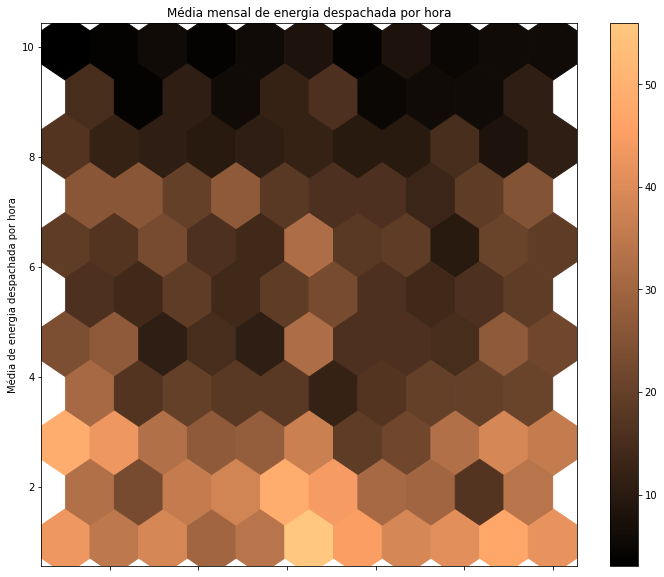

In [ ]:
import numpy as np
df_plotagens.plot.hexbin(
    x = 'mes_referencia',
    y = 'media_energia_despachada_gigawatt_hora',
    reduce_C_function=np.sum,
    gridsize=10,
    cmap='copper',
    figsize=(12,10),
    xlabel='Mês',
    ylabel='Média de energia despachada por hora',
    title='Média mensal de energia despachada por hora'
)

In [ ]:
df_plotagens['ano_referencia'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
      dtype=int32)

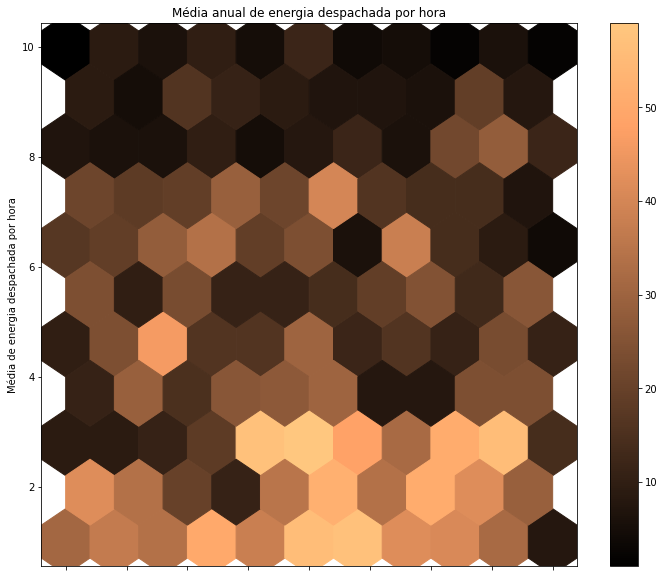

In [ ]:
df_plotagens.plot.hexbin(
    x = 'ano_referencia',
    y = 'media_energia_despachada_gigawatt_hora',
    reduce_C_function=np.sum,
    gridsize=10,
    cmap='copper',
    figsize=(12,10),
    xlabel='Ano',
    ylabel='Média de energia despachada por hora',
    title='Média anual de energia despachada por hora'
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe999e289d0>,
      dtype=object)

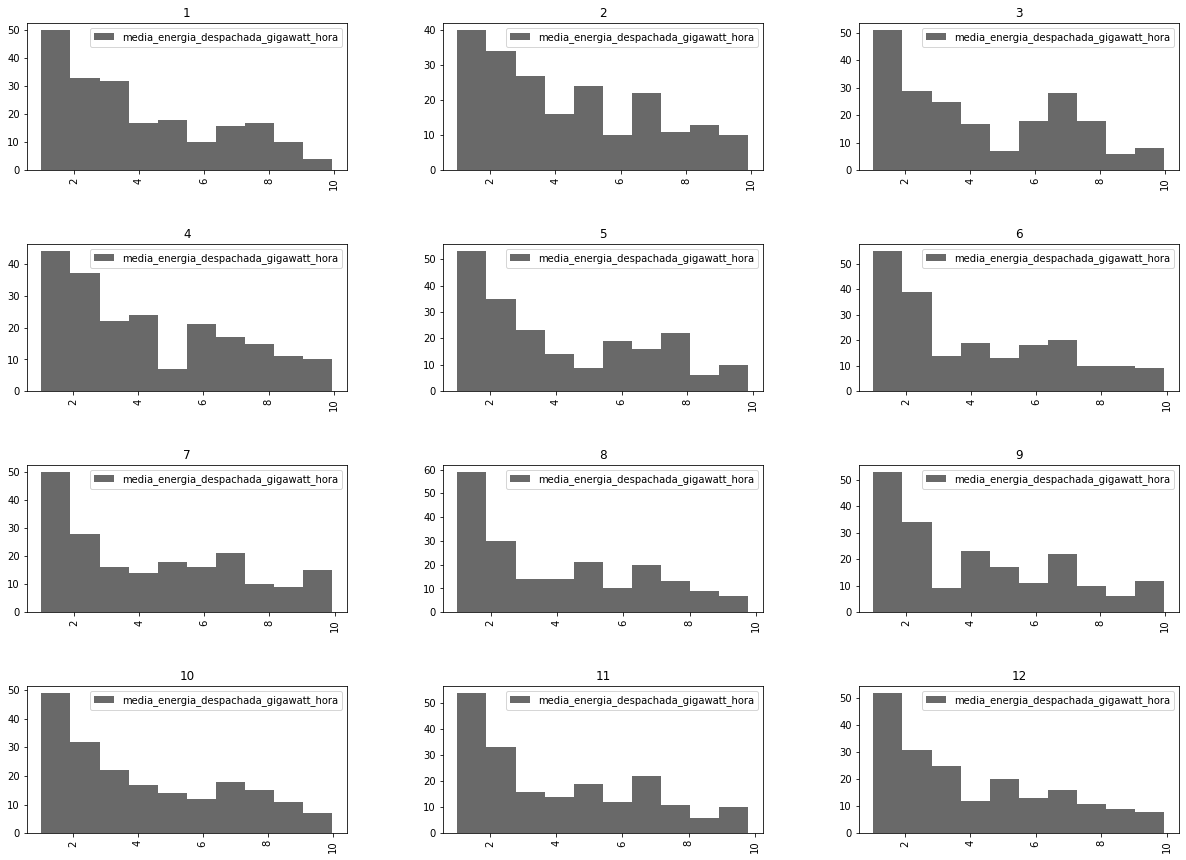

In [ ]:
df_plotagens.hist('media_energia_despachada_gigawatt_hora',
    by=['mes_referencia'],
    figsize=(20,15),
    xlabelsize=10,
    color='dimgrey',
    legend=True
)

Cada um dos anos separados e seus respectivos valores divididos por:

> x - valor de gigawatt por hora

>y - quantidade do mesmo valor

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe97ebf2a90>,
      dtype=object)

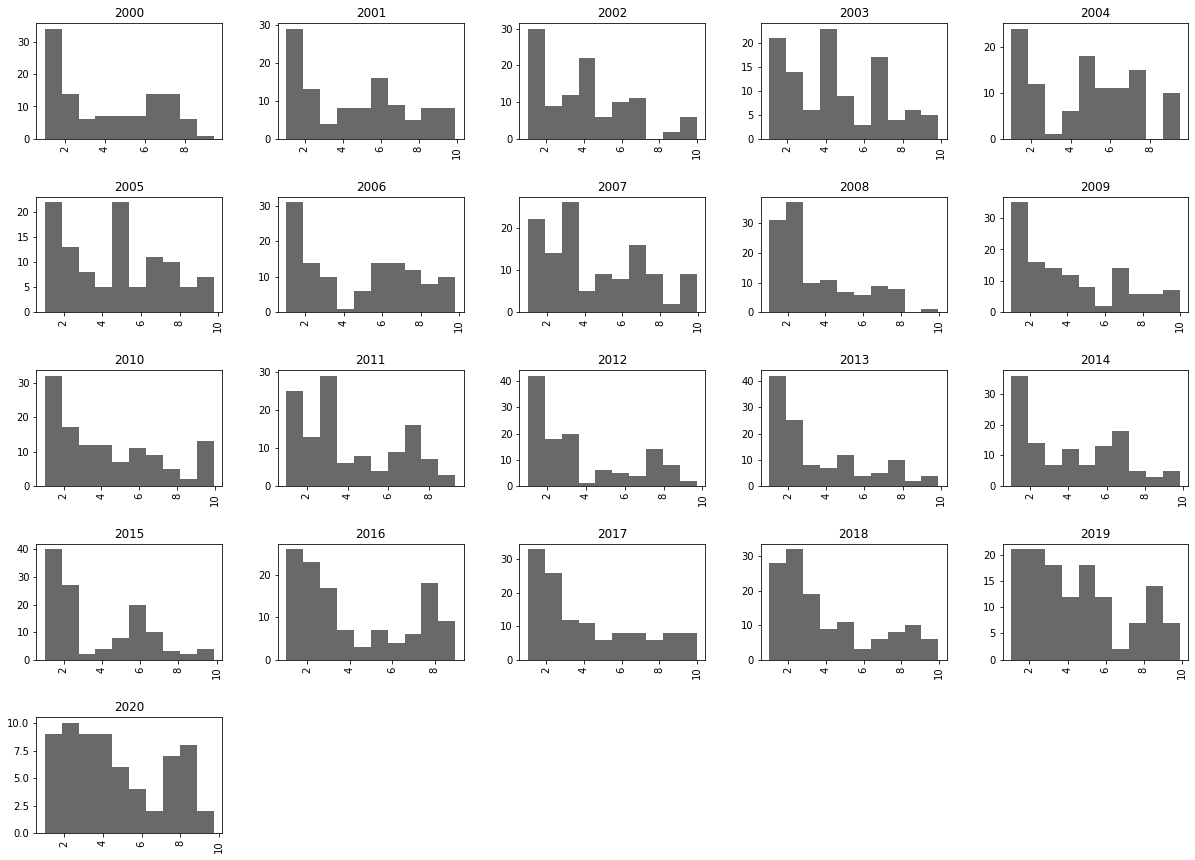

In [ ]:
df_plotagens.hist('media_energia_despachada_gigawatt_hora',
    by=['ano_referencia'],
    figsize=(20,15),
    xlabelsize=10,
    color='dimgrey'
)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe97e70f650>,
      dtype=object)

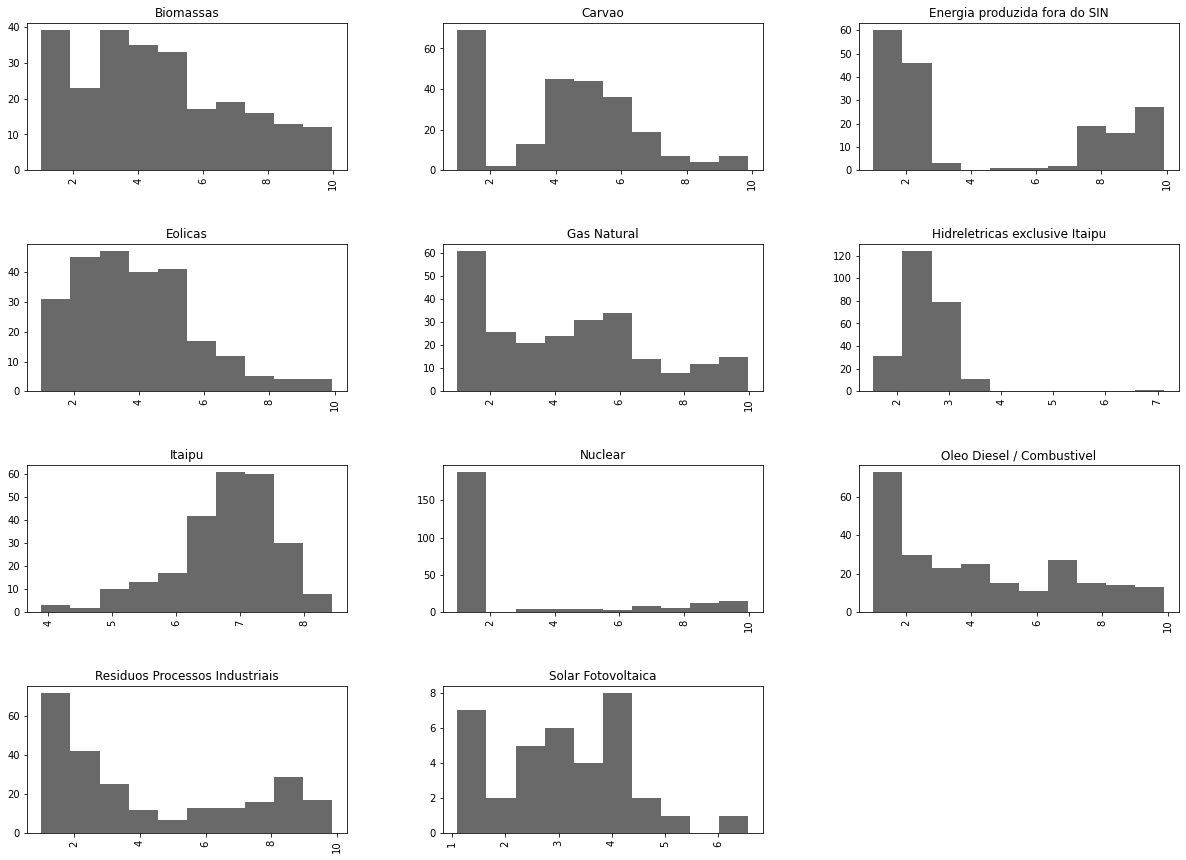

In [ ]:
df_plotagens.hist('media_energia_despachada_gigawatt_hora',
    by=['nome_fonte_geracao'],
    figsize=(20,15),
    xlabelsize=10,
    color='dimgrey'
)

### 3.2. Consumo energia

In [ ]:
df_pandas

,id,Data,TipoConsumidor,Sistema,UF,SetorN1,SetorN2,TensaoN1,TensaoN2,TensaoN3,FaixaDeConsumoN1,FaixaDeConsumoN2,Consumo,Consumidores
0,2,01/01/2013,Cativo,Nordeste,AL,Comercial,Comercial N2,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,27764.000,896
1,3,01/01/2013,Cativo,Nordeste,AL,Comercial,Comercial N2,B - Baixa Tensão,TOTAL,TOTAL,Não aplicável,Não aplicável,24381.000,51071
2,4,01/01/2013,Cativo,Nordeste,AL,Comercial,Outros Serviços e Atividades,B - Baixa Tensão,TOTAL,TOTAL,Não aplicável,Não aplicável,231.000,877
3,5,01/01/2013,Cativo,Nordeste,AL,Comercial,Serviços de Comunicações e Telecomunicações,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,245.000,27
4,6,01/01/2013,Cativo,Nordeste,AL,Comercial,Serviços de Comunicações e Telecomunicações,B - Baixa Tensão,TOTAL,TOTAL,Não aplicável,Não aplicável,2644.000,2838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163672,163674,01/12/2019,Livre,Sul,SC,Industrial,Não identificado,A - Alta Tensão,A-3 - 69 kV,TOTAL,Não aplicável,Não aplicável,62525.972,16
163673,163675,01/12/2019,Livre,Sul,SC,Industrial,Não identificado,A - Alta Tensão,A-3a - 30 a 44 kV,TOTAL,Não aplicável,Não aplicável,6538.496,3
163674,163676,01/12/2019,Livre,Sul,SC,Industrial,Não identificado,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,278507.489,625
163675,163677,01/12/2019,Livre,Sul,SC,Rural,Agroindústria,A - Alta Tensão,"A-4 - 2,3 a 25 kV",TOTAL,Não aplicável,Não aplicável,4842.471,7


In [ ]:
lista = df_pandas.Sistema.unique().tolist()

In [ ]:
lista_contagem = []
for i in lista:
  lista_contagem.append(df_pandas.loc[df_pandas.Sistema == f'{i}', 'Sistema'].count())

In [ ]:
df = pd.DataFrame(list(zip(lista, lista_contagem)), columns = ['Sistema','Contagem'])

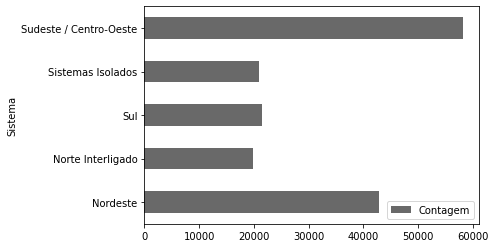

In [ ]:
df.plot.barh(x = 'Sistema', y = 'Contagem', color = 'dimgrey')

In [ ]:
lista = df_pandas.UF.unique().tolist()

In [ ]:
lista_contagem = []
for i in lista:
  lista_contagem.append(df_pandas.loc[df_pandas.UF == f'{i}', 'UF'].count())

In [ ]:
df = pd.DataFrame(list(zip(lista, lista_contagem)), columns = ['UF', 'Contagem'])

Todas as apresentações de barras abaixo são relacionadas a contagem dos valores de cada uma das colunas passadas como parâmetro.

Insight:
1. Qual a contagem por Sistema, UF e Setores?
> Para a resposta da pergunta foram utilizadas as colunas Sistema, UF, SetorN1 e SetorN2. O modelo de apresentação foi a barh para uma visualização mais precisa da contagem de cada um dos parâmetros.

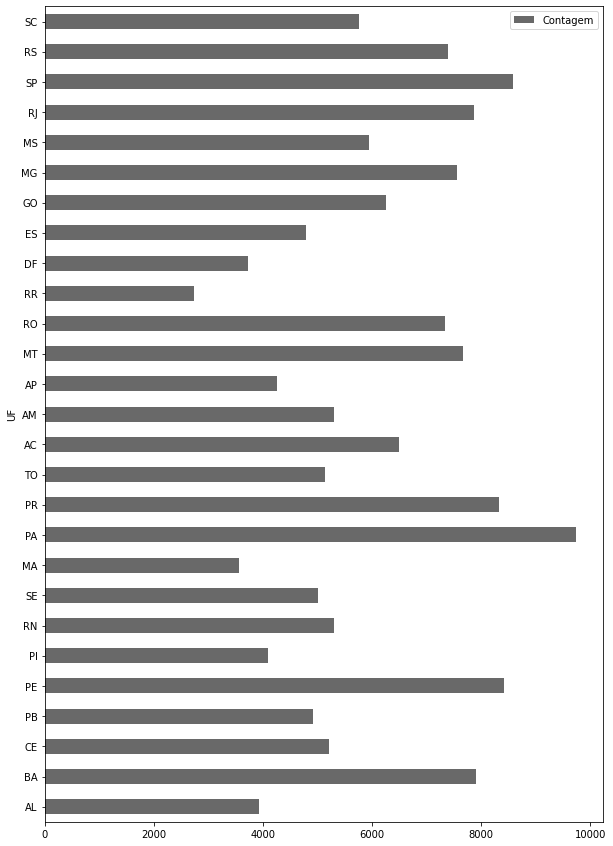

In [ ]:
df.plot.barh(x = 'UF', y = 'Contagem', color = 'dimgrey', figsize=(10,15))

In [ ]:
lista = df_pandas.SetorN1.unique().tolist()

In [ ]:
lista_contagem = []
for i in lista:
  lista_contagem.append(df_pandas.loc[df_pandas.SetorN1 == f'{i}', 'SetorN1'].count())

In [ ]:
df = pd.DataFrame(list(zip(lista, lista_contagem)), columns = ['SetorN1', 'Contagem'])

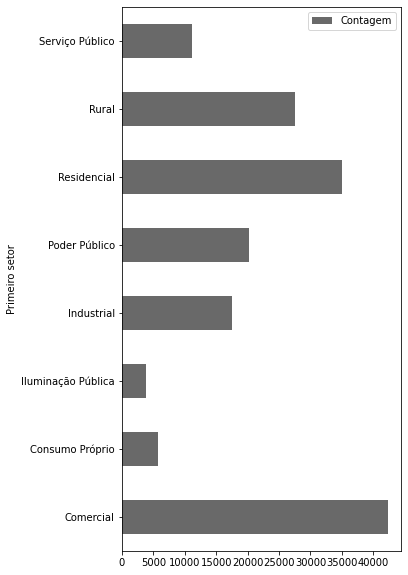

In [ ]:
df.plot.barh(x = 'SetorN1', y = 'Contagem', color = 'dimgrey', xlabel='Primeiro setor', figsize=(5,10))

In [ ]:
lista = df_pandas.SetorN2.unique().tolist()

In [ ]:
lista_contagem = []
for i in lista:
  lista_contagem.append(df_pandas.loc[df_pandas.SetorN2 == f'{i}', 'SetorN2'].count())

In [ ]:
df = pd.DataFrame(list(zip(lista, lista_contagem)), columns = ['SetorN2', 'Contagem'])

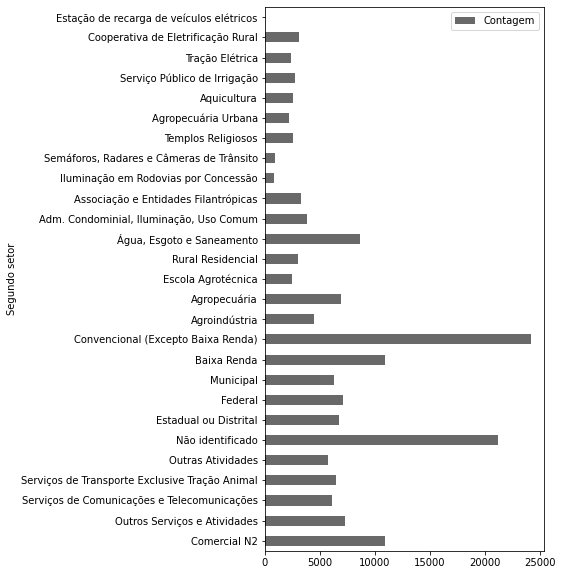

In [ ]:
df.plot.barh(x = 'SetorN2', y = 'Contagem', color = 'dimgrey', xlabel='Segundo setor', figsize=(5,10))

In [ ]:
lista = ['Sistema', 'UF', 'SetorN1', 'SetorN2']
lista_2 = ['Consumo', 'Consumidores']

Utilizando o método describe para a visualização de operações específicas relacionadas aos parâmetros passados ('Sistema', 'UF', 'SetorN1', 'SetorN2')

In [ ]:
try:
  for i in lista:
    for j in lista_2:
      print(f'--------------------- {j} ---------------------')
      print(df_pandas.groupby(by=[f'{i}'])[f'{j}'].describe().sort_values(f'{i}'), '\n')
except Exception as e:
  print(str(e))

--------------------- Consumo ---------------------
                          count          mean            std    min  \
Sistema                                                               
Nordeste                42809.0  11754.936159   25380.137202  0.130   
Norte Interligado       19796.0  11915.189912   58087.823923  0.006   
Sistemas Isolados       20900.0   1170.371223    2964.974506  0.050   
Sudeste / Centro-Oeste  58277.0  32994.801076  122006.473849  0.001   
Sul                     21482.0  27347.475129   51834.908273  0.021   

                              25%       50%          75%          max  
Sistema                                                                
Nordeste                426.87600  3430.534  13101.00000   463444.000  
Norte Interligado       357.75800  2802.500   9959.25000   977741.000  
Sistemas Isolados        34.36775   268.000   1056.25000    76557.000  
Sudeste / Centro-Oeste  428.00000  3412.000  18160.74800  1805455.000  
Sul               

# Salvando DF - PySpark - Consumo Energia

In [ ]:
df_inconsistentes_consumo_spark.write.option("header", True)\
   .csv('/content/spark/consumo')

In [ ]:
df_inconsistentes_consumidores_spark.write.option("header", True)\
   .csv("/content/spark/consumidores")

In [ ]:
df_spark_tratado.write.option("header", True)\
   .csv("/content/spark/tratado")

22/06/11 01:45:39 WARN TaskSetManager: Stage 141 contains a task of very large size (31645 KiB). The maximum recommended task size is 1000 KiB.


# Salvando DF - PySpark - Geração Fonte

In [ ]:
df_spark_geracao_fonte_media_energia.write.option("header", True)\
  .csv("/content/spark/col_fonte_media_energia")

In [ ]:
df_spark_geracao_fonte_final.write.option("header", True)\
   .csv("/content/spark/tratado/geracao_fonte")

# Visualização - SparkSQL - Consumo Energia

In [ ]:
df_spark_tratado.printSchema()

root
 |-- id: long (nullable = true)
 |-- Data: string (nullable = true)
 |-- TipoConsumidor: string (nullable = true)
 |-- Sistema: string (nullable = true)
 |-- UF: string (nullable = true)
 |-- SetorN1: string (nullable = true)
 |-- SetorN2: string (nullable = true)
 |-- TensaoN1: string (nullable = true)
 |-- TensaoN2: string (nullable = true)
 |-- TensaoN3: string (nullable = true)
 |-- FaixaDeConsumoN1: string (nullable = true)
 |-- FaixaDeConsumoN2: string (nullable = true)
 |-- Consumo: float (nullable = true)
 |-- Consumidores: integer (nullable = true)



## 1. Agrupamento

**Métodos utilizados:**
1. ***groupBy***: agrupamento dos parâmetros;
2. ***F.col***: seleciona a coluna passada como parâmetro e permite que eu faça as alterações seguintes e apresente somente ela;
3. ***agg***: para serem acessadas as funções seguinte;
4. ***alias***: altera o nome da coluna na apresentação dos dados;
5. ***sum***: soma do parâmetro passado;
6. ***max***: máximo do parâmetro passado;
7. ***min***: mínimo do parâmetro passado;
8. ***orderBy***: ordenar através do parâmetro passado;
9. ***show***: apresenta os valores;

```
df.groupBy(F.col()).agg(F.sum().alias(), F.max().alias(), F.min().alias()).orderBy().show(df.count())
```

Os métodos seguintes foram utilizados para definir a quantidade de consumidores e consumo por cada um dos parâmetros passados que são os seguintes:

> UF, Sistema, SetorN1, SetorN2

Com isso, podemos identificar UF, Sistema e Setor por quantidade específica tanto de consumo quanto de consumidores de cada um deles em conjunto e/ou individualmente.

In [ ]:
lista_colunas_visualizacao = ['UF', 'Sistema', 'TipoConsumidor', 'SetorN1', 'SetorN2']

In [ ]:
lista_colunas_alvo_visualizacao = ['Consumo', 'Consumidores']

In [ ]:
try:
  for i in lista_colunas_visualizacao:
    for j in lista_colunas_alvo_visualizacao:
      save = df_spark_tratado.groupBy(F.col(f'{i}'))\
      .agg(
          F.sum(f'{j}').alias('Soma'),
          F.max(f'{j}').alias('Máximo'), 
          F.min(f'{j}').alias('Mínimo'))\
      .orderBy(f'{i}')

      save.show(save.count(), truncate = False)

      save.write.option("header", True)\
        .csv(f"/content/pyspark/insights/{i}_{j}")

      print(f'A coluna que está sendo utilizada para soma, max e min é: {j}')
      # input('Digite uma tecla para continuar: ')
      print('---------------------------------------------------------------', '\n')
except Exception as e:
  print(str(e))

+---+------------+---------+------+
|UF |Soma        |Máxido   |Mínimo|
+---+------------+---------+------+
|AC |5027572.0   |8571.0   |1.0   |
|AL |2.6807907E7 |120261.0 |1.0   |
|AM |3.7694785E7 |80241.0  |1.0   |
|AP |6697323.0   |17496.0  |1.0   |
|BA |1.28270665E8|463444.0 |1.0   |
|CE |5.7479264E7 |120323.0 |1.0   |
|DF |3.949267E7  |83196.0  |12.0  |
|ES |6.3579079E7 |330236.0 |1.0   |
|GO |9.0300854E7 |186087.0 |1.0   |
|MA |4.1671213E7 |535055.0 |10.0  |
|MG |2.61250447E8|1550180.0|1.0   |
|MS |2.754092E7  |44700.0  |1.0   |
|MT |4.1776436E7 |60368.0  |1.0   |
|PA |1.16798779E8|977741.0 |1.0   |
|PB |2.7099562E7 |49987.0  |1.0   |
|PE |9.7033088E7 |158984.0 |1.0   |
|PI |2.0020243E7 |37175.0  |1.0   |
|PR |1.16430216E8|358520.0 |1.0   |
|RJ |2.04983083E8|551376.0 |1.0   |
|RN |3.9867106E7 |59182.0  |1.0   |
|RO |1.5610045E7 |56951.0  |1.0   |
|RR |4385064.0   |15918.0  |1.0   |
|RS |1.28943366E8|360594.0 |1.0   |
|SC |1.21882748E8|342377.0 |1.0   |
|SE |1.9580039E7 |67492.0  |

In [ ]:
def visualizacao_consumo(p_cont, s_cont, comparativo, coluna_alvo):
  while s_cont < comparativo:
      save = df_spark_tratado.groupBy(
          F.col(f'{lista_colunas_visualizacao[p_cont]}'), 
          F.col(f'{lista_colunas_visualizacao[s_cont]}')
          )\
      .agg(
          F.sum(f'{coluna_alvo}').alias('Soma'),
          F.max(f'{coluna_alvo}').alias('Máximo'), 
          F.min(f'{coluna_alvo}').alias('Mínimo'))\
      .orderBy([
                f'{lista_colunas_visualizacao[p_cont]}', 
                f'{lista_colunas_visualizacao[s_cont]}'
                ])

      save.show(save.count(), truncate = False)
      
      save.write.option("header", True)\
        .csv(f"/content/pyspark/insights/{lista_colunas_visualizacao[p_cont]}_{lista_colunas_visualizacao[s_cont]}_{coluna_alvo}")

      s_cont += 1
      print(f'A coluna que está sendo utilizada para soma, max e min é: {coluna_alvo}')
      # input('Digite uma tecla para continuar: ')
      print('---------------------------------------------------------------', '\n')

In [ ]:
try:
  for i in lista_colunas_visualizacao:
    for j in lista_colunas_alvo_visualizacao:
      try:
          if i == 'UF':
            visualizacao_consumo(0, 1, 4, f'{j}')
          if i == 'Sistema':
            visualizacao_consumo(1, 2, 4, f'{j}')
          if i == 'TipoConsumidor':
            visualizacao_consumo(2, 3, 4, f'{j}')
          if i == 'SetorN1':
            visualizacao_consumo(3, 4, 5, f'{j}')
      except Exception as e:
        print(str(e))
        continue
except Exception as e:
  print(str(e))

+---+----------------------+------------+---------+------+
|UF |Sistema               |Soma        |Máxido   |Mínimo|
+---+----------------------+------------+---------+------+
|AC |Sistemas Isolados     |920985.0    |3668.0   |1.0   |
|AC |Sudeste / Centro-Oeste|4106587.0   |8571.0   |1.0   |
|AL |Nordeste              |2.6807907E7 |120261.0 |1.0   |
|AM |Norte Interligado     |2.7867279E7 |80241.0  |21.0  |
|AM |Sistemas Isolados     |9827506.0   |76557.0  |1.0   |
|AP |Norte Interligado     |4236485.0   |17496.0  |3.0   |
|AP |Sistemas Isolados     |2460838.0   |15788.0  |1.0   |
|BA |Nordeste              |1.28270665E8|463444.0 |1.0   |
|CE |Nordeste              |5.7479264E7 |120323.0 |1.0   |
|DF |Sudeste / Centro-Oeste|3.949267E7  |83196.0  |12.0  |
|ES |Sudeste / Centro-Oeste|6.3579079E7 |330236.0 |1.0   |
|GO |Sudeste / Centro-Oeste|9.0300854E7 |186087.0 |1.0   |
|MA |Norte Interligado     |4.1671213E7 |535055.0 |10.0  |
|MG |Sudeste / Centro-Oeste|2.61250447E8|1550180.0|1.0  

In [ ]:
def visualizacao_consumo_tres_col(p_cont, s_cont, t_cont, comparativo, coluna_alvo):
  while t_cont < comparativo:
      save = df_spark_tratado.groupBy(
          F.col(f'{lista_colunas_visualizacao[p_cont]}'), 
          F.col(f'{lista_colunas_visualizacao[s_cont]}'), 
          F.col(f'{lista_colunas_visualizacao[t_cont]}')
          )\
      .agg(
          F.sum(f'{coluna_alvo}').alias('Soma'),
          F.max(f'{coluna_alvo}').alias('Máximo'), 
          F.min(f'{coluna_alvo}').alias('Mínimo')
          )\
      .orderBy([
                f'{lista_colunas_visualizacao[p_cont]}', 
                f'{lista_colunas_visualizacao[s_cont]}', 
                f'{lista_colunas_visualizacao[t_cont]}'
                ])
      
      save.show(save.count(), truncate = False)

      save.write.option("header", True)\
        .csv(f"/content/pyspark/insights/{lista_colunas_visualizacao[p_cont]}_{lista_colunas_visualizacao[s_cont]}_{lista_colunas_visualizacao[t_cont]}_{coluna_alvo}")

      s_cont += 1
      t_cont += 1
      
      print(f'A coluna que está sendo utilizada para soma, max e min é: {coluna_alvo}')
      #input('Digite uma tecla para continuar: ')
      print('---------------------------------------------------------------', '\n')

uf sistema tipo consumidor setor1 setor2

In [ ]:
try:
  for i in lista_colunas_visualizacao:
    for j in lista_colunas_alvo_visualizacao:
        if i == 'UF':
          visualizacao_consumo_tres_col(0, 1, 2, 4, f'{j}')
        if i == 'Sistema':
          visualizacao_consumo_tres_col(1, 2, 3, 4, f'{j}')
        if i == 'TipoConsumidor':
          visualizacao_consumo_tres_col(2, 3, 4, 5, f'{j}')
except Exception as e:
  print(str(e))

In [ ]:
try:
  for i in lista_colunas_alvo_visualizacao:
    save = df_spark_tratado.groupBy(F.col('UF'), F.col('Sistema'), F.col('SetorN1'), F.col('SetorN2'))\
      .agg(
          F.sum(f'{i}').alias('Soma'),
          F.max(f'{i}').alias('Máximo'), 
          F.min(f'{i}').alias('Mínimo'))\
      .orderBy(['UF', 'Sistema', 'SetorN1', 'SetorN2'])

    save.show(save.count(), truncate = False)

    save.write.option("header", True)\
      .csv(f"/content/pyspark/insights/UF_Sistema_SetorN1_SetorN2_{i}")
except Exception as e:
  print(str(e))

## 2. Window Functions

**Métodos utilizados:**
1. ***groupBy***: agrupa os valores;
2. ***F.col***: seleciona a coluna passada como parâmetro;
3. ***count***: contagem dos dados;
4. ***orderBy***: ordena os dados a partir do parâmetro passado;
5. ***show***: retorna os dados;
6. ***count***: contagem dos dados - utilizado para retornar todos os dados, por isso foi passado dentro do show;



```
df.groupBy(F.col()).count().orderBy().show(df.count())
```

Colunas utilizadas para análise:
> UF, Sistema, SetorN1, SetorN2

As colunas utilizadas foram selecionadas porque com elas se pode ter a contagem de cada uma das mesmas, o que auxilia no processo de análise com os agrupamentos acima.

In [ ]:
try:
  for i in lista_colunas_visualizacao:
    save = df_spark_tratado.groupBy(F.col(f'{i}'))\
      .count().orderBy(f'{i}')
    
    save.show(save.count(), truncate = False)

    save.write.option("header", True)\
      .csv(f"/content/pyspark/insights_window/{i}")
except Exception as e:
  print(str(e))

+---+-----+
|UF |count|
+---+-----+
|AC |6643 |
|AL |4030 |
|AM |5443 |
|AP |4370 |
|BA |8121 |
|CE |5341 |
|DF |3824 |
|ES |4901 |
|GO |6406 |
|MA |3654 |
|MG |7739 |
|MS |6076 |
|MT |7853 |
|PA |9966 |
|PB |5046 |
|PE |8622 |
|PI |4182 |
|PR |8519 |
|RJ |8043 |
|RN |5423 |
|RO |7514 |
|RR |2802 |
|RS |7623 |
|SC |5956 |
|SE |5129 |
|SP |8789 |
|TO |5256 |
+---+-----+

+----------------------+-----+
|Sistema               |count|
+----------------------+-----+
|Nordeste              |43860|
|Norte Interligado     |20294|
|Sistemas Isolados     |21379|
|Sudeste / Centro-Oeste|59640|
|Sul                   |22098|
+----------------------+-----+

+--------------+------+
|TipoConsumidor|count |
+--------------+------+
|Cativo        |150586|
|Livre         |16685 |
+--------------+------+

+------------------+-----+
|SetorN1           |count|
+------------------+-----+
|Comercial         |43271|
|Consumo Próprio   |5960 |
|Iluminação Pública|3872 |
|Industrial        |17907|
|Poder Públic

In [ ]:
def window_function(pr_cont, sg_cont, comparativo):
  while sg_cont <= comparativo:
    save = df_spark_tratado.groupBy(
        F.col(f'{lista_colunas_visualizacao[pr_cont]}'), 
        F.col(f'{lista_colunas_visualizacao[sg_cont]}'))\
      .count().orderBy([
                        f'{lista_colunas_visualizacao[pr_cont]}', 
                        f'{lista_colunas_visualizacao[sg_cont]}'
                        ])

    save.show(save.count(), truncate = False)
    save.write.option("header", True)\
      .csv(f"/content/pyspark/insights_window/{lista_colunas_visualizacao[pr_cont]}_{lista_colunas_visualizacao[sg_cont]}")
    sg_cont += 1
    # input('Digite uma tecla para continuar: ')
    print('---------------------------------------------------------------', '\n')

In [ ]:
try:
  for i in lista_colunas_visualizacao:
    if i == 'UF':
      window_function(0, 1, 4)
    elif i == 'Sistema':
      window_function(1, 2, 4)
    elif i == 'TipoConsumidor':
      window_function(2, 3, 4)
    elif i == 'SetorN1':
      window_function(3, 4, 4)
except Exception as e:
  print(str(e))

+---+----------------------+-----+
|UF |Sistema               |count|
+---+----------------------+-----+
|AC |Sistemas Isolados     |2948 |
|AC |Sudeste / Centro-Oeste|3695 |
|AL |Nordeste              |4030 |
|AM |Norte Interligado     |2870 |
|AM |Sistemas Isolados     |2573 |
|AP |Norte Interligado     |2108 |
|AP |Sistemas Isolados     |2262 |
|BA |Nordeste              |8121 |
|CE |Nordeste              |5341 |
|DF |Sudeste / Centro-Oeste|3824 |
|ES |Sudeste / Centro-Oeste|4901 |
|GO |Sudeste / Centro-Oeste|6406 |
|MA |Norte Interligado     |3654 |
|MG |Sudeste / Centro-Oeste|7739 |
|MS |Sudeste / Centro-Oeste|6076 |
|MT |Sistemas Isolados     |1813 |
|MT |Sudeste / Centro-Oeste|6040 |
|PA |Norte Interligado     |6398 |
|PA |Sistemas Isolados     |3568 |
|PB |Nordeste              |5046 |
|PE |Nordeste              |6588 |
|PE |Sistemas Isolados     |2034 |
|PI |Nordeste              |4182 |
|PR |Sul                   |8519 |
|RJ |Sudeste / Centro-Oeste|8043 |
|RN |Nordeste       

In [ ]:
def window_function_tres(pr_cont, sg_cont, tr_cont, comparativo):
  while tr_cont < comparativo:
    save = df_spark_tratado.groupBy(
        F.col(f'{lista_colunas_visualizacao[pr_cont]}'), 
        F.col(f'{lista_colunas_visualizacao[sg_cont]}'), 
        F.col(f'{lista_colunas_visualizacao[tr_cont]}'
        ))\
    .count().orderBy([
                      f'{lista_colunas_visualizacao[pr_cont]}', 
                      f'{lista_colunas_visualizacao[sg_cont]}', 
                      f'{lista_colunas_visualizacao[tr_cont]}'
                    ])

    save.show(save.count(), truncate = False)
    #save.write.option("header", True)\
      #.csv(f"/content/pyspark/insights_window/{lista_colunas_visualizacao[pr_cont]}_{lista_colunas_visualizacao[sg_cont]}_{lista_colunas_visualizacao[tr_cont]}")
    sg_cont += 1
    tr_cont += 1
    # input('Digite uma tecla para continuar: ')
    print('---------------------------------------------------------------', '\n')

In [ ]:
try:
  for i in lista_colunas_visualizacao:
    if i == 'UF':
      window_function_tres(0, 1, 2, 5)
    elif i == 'Sistema':
      window_function_tres(1, 2, 3, 5)
    elif i == 'TipoConsumidor':
      window_function_tres(2, 3, 4, 5)
except Exception as e:
  print(str(e))

+---+----------------------+--------------+-----+
|UF |Sistema               |TipoConsumidor|count|
+---+----------------------+--------------+-----+
|AC |Sistemas Isolados     |Cativo        |2948 |
|AC |Sudeste / Centro-Oeste|Cativo        |3609 |
|AC |Sudeste / Centro-Oeste|Livre         |86   |
|AL |Nordeste              |Cativo        |3808 |
|AL |Nordeste              |Livre         |222  |
|AM |Norte Interligado     |Cativo        |2673 |
|AM |Norte Interligado     |Livre         |197  |
|AM |Sistemas Isolados     |Cativo        |2552 |
|AM |Sistemas Isolados     |Livre         |21   |
|AP |Norte Interligado     |Cativo        |2108 |
|AP |Sistemas Isolados     |Cativo        |2262 |
|BA |Nordeste              |Cativo        |6969 |
|BA |Nordeste              |Livre         |1152 |
|CE |Nordeste              |Cativo        |4867 |
|CE |Nordeste              |Livre         |474  |
|DF |Sudeste / Centro-Oeste|Cativo        |3541 |
|DF |Sudeste / Centro-Oeste|Livre         |283  |


In [ ]:
try:
  save = df_spark_tratado.groupBy(F.col('UF'), F.col('Sistema'), F.col('SetorN1'), F.col('SetorN2'))\
    .count().orderBy(['UF', 'Sistema', 'SetorN1', 'SetorN2'])

  save.show(save.count(), truncate = False)
  save.write.option("header", True)\
        .csv(f"/content/pyspark/insights_window/UF_Sistema_SetorN1_SetorN2")
except Exception as e:
  print(str(e))

+---+----------------------+------------------+----------------------------------------------+-----+
|UF |Sistema               |SetorN1           |SetorN2                                       |count|
+---+----------------------+------------------+----------------------------------------------+-----+
|AC |Sistemas Isolados     |Comercial         |Comercial N2                                  |148  |
|AC |Sistemas Isolados     |Comercial         |Outros Serviços e Atividades                  |173  |
|AC |Sistemas Isolados     |Comercial         |Semáforos, Radares e Câmeras de Trânsito      |4    |
|AC |Sistemas Isolados     |Comercial         |Serviços de Comunicações e Telecomunicações   |123  |
|AC |Sistemas Isolados     |Comercial         |Serviços de Transporte Exclusive Tração Animal|121  |
|AC |Sistemas Isolados     |Comercial         |Templos Religiosos                            |12   |
|AC |Sistemas Isolados     |Consumo Próprio   |Outras Atividades                           

# Visualização - SparkSQL - Geração Fonte

## 1. Agrupamentos

**Métodos utilizados:**
1. ***groupBy***: agrupamento dos parâmetros;
2. ***F.col***: seleciona a coluna passada como parâmetro e permite que eu faça as alterações seguintes e apresente somente ela;
3. ***agg***: para serem acessadas as funções seguinte;
4. ***alias***: altera o nome da coluna na apresentação dos dados;
5. ***sum***: soma do parâmetro passado;
6. ***max***: máximo do parâmetro passado;
7. ***min***: mínimo do parâmetro passado;
8. ***orderBy***: ordenar através do parâmetro passado;
9. ***show***: apresenta os valores;

```
df.groupBy(F.col()).agg(F.sum().alias(), F.max().alias(), F.min().alias()).orderBy().show(df.count())
```

Os métodos seguintes foram utilizados para definir a quantidade de energia despachada separados por:
> nome_fonte_geracao, mes_referencia, ano_referencia

Com isso, podemos identificar qual o nome da fonte que tem a maior média de energia despachada por hora, quais os meses que tiveram a maior e menor média e isso também relacionado ao ano.

In [ ]:
lista_geracao_fonte = ['nome_fonte_geracao', 'mes_referencia', 'ano_referencia']
lista_geracao_fonte_alias = ['Nome da fonte de geração', 'Mês de referência', 'Ano de referência']

In [ ]:
try:
  for i in lista_geracao_fonte:
    try:
      alias = ''
      if i == 'nome_fonte_geracao':
        alias = lista_geracao_fonte_alias[0]
      elif i == 'mes_referencia':
        alias = lista_geracao_fonte_alias[1]
      elif i == 'ano_referencia':
        alias = lista_geracao_fonte_alias[2]

      save = df_spark_geracao_fonte_final.groupBy(F.col(f'{i}').alias(f'{alias}'))\
        .agg(
            F.sum('media_energia_despachada_gigawatt_hora').alias('Total de gigawatt por hora'), 
            F.max('media_energia_despachada_gigawatt_hora').alias('Máximo de gigawatt por hora'), 
            F.min('media_energia_despachada_gigawatt_hora').alias('Mínimo de gigawatt por hora'))\
        .orderBy(f'{i}')

      save.show(save.count(), truncate = False)
      save.write.option("header", True)\
          .csv(f"/content/pyspark/insights/{i}")
    except Exception as e:
      print(str(e))
      continue
except Exception as e:
  print(str(e))

In [ ]:
try:
  df_spark_geracao_fonte_final.groupBy([
                                        F.col('nome_fonte_geracao').alias('Nome da Fonte de Geração'), 
                                        F.col('mes_referencia').alias('Mês de referência')
                                      ])\
    .agg(
        F.sum('media_energia_despachada_gigawatt_hora').alias('Total de gigawatt por hora no mês'), 
        F.max('media_energia_despachada_gigawatt_hora').alias('Máximo de gigawatt por hora no mês'), 
        F.min('media_energia_despachada_gigawatt_hora').alias('Mínimo de gigawatt por hora no mês'))\
    .orderBy(['nome_fonte_geracao', 'mes_referencia'])\
    .show(df_spark_geracao_fonte_final.count(), truncate=False)
except Exception as e:
  print(str(e))

+------------------------------+-----------------+---------------------------------+----------------------------------+----------------------------------+
|Nome da Fonte de Geração      |Mês de referência|Total de gigawatt por hora no mês|Máxido de gigawatt por hora no mês|Mínimo de gigawatt por hora no mês|
+------------------------------+-----------------+---------------------------------+----------------------------------+----------------------------------+
|Biomassas                     |1                |74.33999919891357                |3.54                              |3.54                              |
|Biomassas                     |2                |74.33999919891357                |3.54                              |3.54                              |
|Biomassas                     |3                |74.33999919891357                |3.54                              |3.54                              |
|Biomassas                     |4                |74.33999919891357   

In [ ]:
try:
  df_spark_geracao_fonte_final.groupBy([
                                        F.col('nome_fonte_geracao').alias('Nome da Fonte de Geração'), 
                                        F.col('ano_referencia').alias('Ano de referência')
                                      ])\
    .agg(
        F.sum('media_energia_despachada_gigawatt_hora').alias('Total de gigawatt por hora no ano'), 
        F.max('media_energia_despachada_gigawatt_hora').alias('Máximo de gigawatt por hora no ano'), 
        F.min('media_energia_despachada_gigawatt_hora').alias('Mínimo de gigawatt por hora no ano'))\
    .orderBy(['nome_fonte_geracao', 'ano_referencia'])\
    .show(df_spark_geracao_fonte_final.count(), truncate=False)
except Exception as e:
  print(str(e))

+------------------------------+-----------------+---------------------------------+----------------------------------+----------------------------------+
|Nome da Fonte de Geração      |Ano de referência|Total de gigawatt por hora no ano|Máxido de gigawatt por hora no ano|Mínimo de gigawatt por hora no ano|
+------------------------------+-----------------+---------------------------------+----------------------------------+----------------------------------+
|Biomassas                     |2000             |42.47999954223633                |3.54                              |3.54                              |
|Biomassas                     |2001             |42.47999954223633                |3.54                              |3.54                              |
|Biomassas                     |2002             |42.47999954223633                |3.54                              |3.54                              |
|Biomassas                     |2003             |42.47999954223633   

In [ ]:
try:
  df_spark_geracao_fonte_final.groupBy([
                                        F.col('nome_fonte_geracao').alias('Nome da Fonte de Geração'),
                                        F.col('mes_referencia').alias('Mês de referência'), 
                                        F.col('ano_referencia').alias('Ano de referência')
                                      ])\
    .agg(
        F.sum('media_energia_despachada_gigawatt_hora').alias('Total de gigawatt por hora no ano por mês'), 
        F.max('media_energia_despachada_gigawatt_hora').alias('Máximo de gigawatt por hora no ano por mês'), 
        F.min('media_energia_despachada_gigawatt_hora').alias('Mínimo de gigawatt por hora no ano por mês'))\
    .orderBy(['nome_fonte_geracao', 'mes_referencia', 'ano_referencia'])\
    .show(df_spark_geracao_fonte_final.count(), truncate=False)
except Exception as e:
  print(str(e))

+------------------------------+-----------------+-----------------+-----------------------------------------+------------------------------------------+------------------------------------------+
|Nome da Fonte de Geração      |Mês de referência|Ano de referência|Total de gigawatt por hora no ano por mês|Máxido de gigawatt por hora no ano por mês|Mínimo de gigawatt por hora no ano por mês|
+------------------------------+-----------------+-----------------+-----------------------------------------+------------------------------------------+------------------------------------------+
|Biomassas                     |1                |2000             |3.5399999618530273                       |3.54                                      |3.54                                      |
|Biomassas                     |1                |2001             |3.5399999618530273                       |3.54                                      |3.54                                      |
|Biomassas     

## 2. Window Functions

**Métodos utilizados:**
1. ***groupBy***: utilizado para agrupar os valores;
2. ***F.col***: me retorna a minha coluna passada como parâmetro. Utilização para que o alias pudesse ser utilizado em conjunto;
3. ***alias***: modifica o nome da minha coluna na visualização;
4. ***count***: contagem;
5. ***orderBy***: ordena os dados a partir do(s) parâmetros passados;
6. ***show***: retorna os valores;

As windows functions nessa situação retornaram as contagens exatas de cada um dos parâmetros passados nas funções;



```
df.groupBy(F.col().alias()).count().orderBy().show()
```

Os métodos utilizados foram para especificar cada uma das contagens relacionadas as fontes de geração, os meses e os anos para uma análise apurada relacionada a quais fontes de geração estão mais presentes por mês e/ou ano e quais meses e/ou anos se tem mais contagem de geração de energia.

In [ ]:
try:
  for i in lista_geracao_fonte:
    if i == 'nome_fonte_geracao':
      alias = lista_geracao_fonte_alias[0]
    elif i == 'mes_referencia':
      alias = lista_geracao_fonte_alias[1]
    elif i == 'ano_referencia':
      alias = lista_geracao_fonte_alias[2]
    save = df_spark_geracao_fonte_final.groupBy(F.col(f'{i}').alias(f'{alias}'))\
    .count().orderBy(f'{i}')

    save.show(save.count(), truncate = False)

    save.write.option("header", True)\
      .csv(f"/content/pyspark/insights_window/{i}")
except Exception as e:
  print(str(e))

+------------------------------+-----+
|Nome da fonte de geração      |count|
+------------------------------+-----+
|Biomassas                     |246  |
|Carvao                        |246  |
|Energia produzida fora do SIN |175  |
|Eolicas                       |246  |
|Gas Natural                   |246  |
|Hidreletricas exclusive Itaipu|246  |
|Itaipu                        |246  |
|Nuclear                       |246  |
|Oleo Diesel / Combustivel     |246  |
|Residuos Processos Industriais|246  |
|Solar Fotovoltaica            |36   |
+------------------------------+-----+

+-----------------+-----+
|Mês de referência|count|
+-----------------+-----+
|1                |207  |
|2                |207  |
|3                |207  |
|4                |208  |
|5                |207  |
|6                |207  |
|7                |197  |
|8                |197  |
|9                |197  |
|10               |197  |
|11               |197  |
|12               |197  |
+-----------------+-----

> Contagem por nome da fonte de geração e mês de referência

In [ ]:
try:
  save = df_spark_geracao_fonte_final.groupBy([
                                        F.col('nome_fonte_geracao').alias('Nome da fonte de geração'), 
                                        F.col('mes_referencia').alias('Mês de referência')
                                      ])\
                              .count()\
                              .orderBy(['nome_fonte_geracao', 'mes_referencia'])
  save.show(save.count(), truncate = False)

  save.write.option("header", True)\
      .csv(f"/content/pyspark/insights_window/nome_fonte_mes")
except Exception as e:
  print(str(e))

+------------------------------+-----------------+-----+
|Nome da fonte de geração      |Mês de referência|count|
+------------------------------+-----------------+-----+
|Biomassas                     |1                |21   |
|Biomassas                     |2                |21   |
|Biomassas                     |3                |21   |
|Biomassas                     |4                |21   |
|Biomassas                     |5                |21   |
|Biomassas                     |6                |21   |
|Biomassas                     |7                |20   |
|Biomassas                     |8                |20   |
|Biomassas                     |9                |20   |
|Biomassas                     |10               |20   |
|Biomassas                     |11               |20   |
|Biomassas                     |12               |20   |
|Carvao                        |1                |21   |
|Carvao                        |2                |21   |
|Carvao                        

> Contagem por mês de referência e ano de referência

In [ ]:
try:
  save = df_spark_geracao_fonte_final.groupBy([
                                        F.col('mes_referencia').alias('Mês de referência'), 
                                        F.col('ano_referencia').alias('Ano de referência')
                                      ])\
                              .count()\
                              .orderBy(['mes_referencia', 'ano_referencia'])
  save.show(save.count(), truncate = False)

  save.write.option("header", True)\
    .csv(f"/content/pyspark/insights_window/mes_ano")
except Exception as e:
  print(str(e))

+-----------------+-----------------+-----+
|Mês de referência|Ano de referência|count|
+-----------------+-----------------+-----+
|1                |2000             |9    |
|1                |2001             |9    |
|1                |2002             |9    |
|1                |2003             |9    |
|1                |2004             |9    |
|1                |2005             |9    |
|1                |2006             |10   |
|1                |2007             |10   |
|1                |2008             |10   |
|1                |2009             |10   |
|1                |2010             |10   |
|1                |2011             |10   |
|1                |2012             |10   |
|1                |2013             |10   |
|1                |2014             |10   |
|1                |2015             |10   |
|1                |2016             |10   |
|1                |2017             |10   |
|1                |2018             |11   |
|1                |2019         

> Contagem por nome da fonte de geração e ano de referência

In [ ]:
try:
  save = df_spark_geracao_fonte_final.groupBy([
                                        F.col('nome_fonte_geracao').alias('Nome da fonte de geração'), 
                                        F.col('ano_referencia').alias('Ano de referência')
                                      ])\
                              .count()\
                              .orderBy(['nome_fonte_geracao', 'ano_referencia'])
  save.show(save.count(), truncate = False)

  save.write.option("header", True)\
    .csv(f"/content/pyspark/insights_window/nome_ano")
except Exception as e:
  print(str(e))

+------------------------------+-----------------+-----+
|Nome da fonte de geração      |Ano de referência|count|
+------------------------------+-----------------+-----+
|Biomassas                     |2000             |12   |
|Biomassas                     |2001             |12   |
|Biomassas                     |2002             |12   |
|Biomassas                     |2003             |12   |
|Biomassas                     |2004             |12   |
|Biomassas                     |2005             |12   |
|Biomassas                     |2006             |12   |
|Biomassas                     |2007             |12   |
|Biomassas                     |2008             |12   |
|Biomassas                     |2009             |12   |
|Biomassas                     |2010             |12   |
|Biomassas                     |2011             |12   |
|Biomassas                     |2012             |12   |
|Biomassas                     |2013             |12   |
|Biomassas                     

> Contagem por nome, mês e ano de referência

In [ ]:
try:
  df_spark_geracao_fonte_final.groupBy([
                                        F.col('nome_fonte_geracao').alias('Nome da fonte de geração'),
                                        F.col('mes_referencia').alias('Mês de referência'), 
                                        F.col('ano_referencia').alias('Ano de referência')
                                      ])\
                              .count()\
                              .orderBy(['nome_fonte_geracao', 'mes_referencia', 'ano_referencia'])
  save.show(save.count(), truncate = False)

  save.write.option("header", True)\
    .csv(f"/content/pyspark/insights_window/nome_mes_ano")
except Exception as e:
  print(str(e))

+------------------------------+-----------------+-----+
|Nome da fonte de geração      |Ano de referência|count|
+------------------------------+-----------------+-----+
|Biomassas                     |2000             |12   |
|Biomassas                     |2001             |12   |
|Biomassas                     |2002             |12   |
|Biomassas                     |2003             |12   |
|Biomassas                     |2004             |12   |
|Biomassas                     |2005             |12   |
|Biomassas                     |2006             |12   |
|Biomassas                     |2007             |12   |
|Biomassas                     |2008             |12   |
|Biomassas                     |2009             |12   |
|Biomassas                     |2010             |12   |
|Biomassas                     |2011             |12   |
|Biomassas                     |2012             |12   |
|Biomassas                     |2013             |12   |
|Biomassas                     

# Processos com Bucket - Consumo Energia

#### 1.1. Autenticação

In [ ]:
auth.authenticate_user()

project_id = ''
!gcloud config set project {project_id}

Updated property [core/project].


#### 1.2. Criação do Bucket

Dando nome ao meu Bucket

In [ ]:
nome_bucket = 'bucketprojeto_final'

Criando o meu Bucket diretamente no GCP

In [ ]:
!gsutil mb -l SOUTHAMERICA-EAST1 gs://{nome_bucket}

Creating gs://bucketprojeto_final/...


#### 1.3. Inserção

In [ ]:
!gsutil cp /content/spark/consumidores/df_spark_consumidores.csv gs://{nome_bucket}/DataFrames/

Copying file:///content/spark/consumidores/df_spark_consumidores.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/3.0 KiB.                                      


In [ ]:
!gsutil cp /content/spark/consumo/df_spark_consumo.csv gs://{nome_bucket}/DataFrames/

Copying file:///content/spark/consumo/df_spark_consumo.csv [Content-Type=text/csv]...
-
Operation completed over 1 objects/61.0 KiB.                                     


In [ ]:
!gsutil cp /content/spark/tratado/df_spark_tratado.csv gs://{nome_bucket}/Tratados/

Copying file:///content/spark/tratado/df_spark_tratado.csv [Content-Type=text/csv]...
\
Operation completed over 1 objects/24.5 MiB.                                     


O comando utiliza o -r para copiar um diretório

In [ ]:
!gsutil cp -r /content/pyspark/insights gs://{nome_bucket}/

In [ ]:
!gsutil cp -r /content/pyspark/insights_window gs://{nome_bucket}/

In [ ]:
!gsutil cp /content/df_pandas_Consumo_Energia.csv gs://{nome_bucket}/Tratados/

Copying file:///content/df_pandas_Consumo_Energia.csv [Content-Type=text/csv]...
\
Operation completed over 1 objects/25.0 MiB.                                     


In [ ]:
!gsutil cp /content/geracao_fonte_tratado.csv gs://{nome_bucket}/Tratados

Copying file:///content/geracao_fonte_tratado.csv [Content-Type=text/csv]...
/ [1 files][ 94.2 KiB/ 94.2 KiB]                                                
Operation completed over 1 objects/94.2 KiB.                                     


#### 1.4. Leitura

In [ ]:
!gsutil cat gs://{nome_bucket}/Tratados/df_spark_tratado.csv

In [ ]:
!gsutil cat gs://{nome_bucket}/Tratados/df_spark_consumidores.csv

In [ ]:
!gsutil cat gs://{nome_bucket}/Tratados/df_spark_consumo.csv

# Processos com Bucket - Geração por fonte

### 1. PySpark

#### 1.1. Autenticação

In [ ]:
auth.authenticate_user()

project_id = ''
!gcloud config set project {project_id}

Updated property [core/project].


#### 1.2. Inserção

In [ ]:
nome_bucket = ''

In [ ]:
!gsutil cp /content/spark/col_fonte_media_energia/coluna_fonte_media_energia.csv gs://{nome_bucket}/DataFrames/

CommandException: No URLs matched: /content/spark/col_fonte_media_energia/coluna_fonte_media_energia.csv


In [ ]:
!gsutil cp /content/spark/tratado/df_spark_geracao_tratado.csv gs://{nome_bucket}/Tratados/

Copying file:///content/spark/tratado/df_spark_geracao_tratado.csv [Content-Type=text/csv]...
\
Operation completed over 1 objects/89.5 KiB.                                     


#### 1.3. Leitura

In [ ]:
!gsutil cat gs://{nome_bucket}/DataFrames/coluna_fonte_media_energia.csv

In [ ]:
!gsutil cat gs://{nome_bucket}/Tratados/df_spark_geracao_tratado.csv

id_geracao_fonte,nome_fonte_geracao,media_energia_despachada_gigawatt_hora,mes_referencia,ano_referencia,data_processamento
1,Hidreletricas exclusive Itaipu,2.11,1,2000,nan
2,Itaipu,6.52,1,2000,nan
3,Oleo Diesel / Combustivel,1.12,1,2000,nan
4,Gas Natural,5.13,1,2000,nan
5,Carvao,7.73,1,2000,nan
6,Eolicas,3.97,1,2000,nan
7,Biomassas,1.17,1,2000,nan
8,Nuclear,4.19,1,2000,nan
9,Residuos Processos Industriais,4.92,1,2000,nan
10,Energia produzida fora do SIN,"",1,2000,nan
11,Hidreletricas exclusive Itaipu,2.05,2,2000,nan
12,Itaipu,6.36,2,2000,nan
13,Oleo Diesel / Combustivel,6.92,2,2000,nan
14,Gas Natural,5.81,2,2000,nan
15,Carvao,7.26,2,2000,nan
16,Eolicas,2.05,2,2000,nan
17,Biomassas,3.17,2,2000,nan
18,Nuclear,4.01,2,2000,nan
19,Residuos Processos Industriais,6.48,2,2000,nan
20,Energia produzida fora do SIN,"",2,2000,nan
21,Hidreletricas exclusive Itaipu,2.12,3,2000,nan
22,Itaipu,7.59,3,2000,nan
23,Oleo Diesel / Combustivel,7.82,3,2000,nan
24,Gas Natural,5.13,3,2000,nan
25,Carvao,6.86,3,

# Inserindo no MongoDB

## 1. Conexão

In [ ]:
try:
  client = MongoClient('')
  db = client.get_database('')
  colection = db.consumo_energia
except Exception as e:
  print(str(e))

In [ ]:
db_nova_collection = db['']

In [ ]:
colecao = db_nova_collection

In [ ]:
df_insercao = df_spark_geracao_fonte_final.toPandas()

In [ ]:
df_insercao.nome_fonte_geracao.replace('Itaipu', 'Hidrelétricas de Itaipu', inplace = True)

In [ ]:
df_insercao.dtypes

id_geracao_fonte                            int32
nome_fonte_geracao                         object
media_energia_despachada_gigawatt_hora    float32
mes_referencia                              int32
ano_referencia                              int32
data_processamento                         object
dtype: object

In [ ]:
try:
  for i, row in df_insercao.iterrows():
    novo_documento = {'id': row.id_geracao_fonte, 'nome_fonte': row.nome_fonte_geracao, 'media_energia_despachada_GW_hora': row.media_energia_despachada_gigawatt_hora, 'mes_referencia': row.mes_referencia, 'ano_referencia': row.ano_referencia, 'data_processamento': row.data_processamento}
    colecao.insert_one(novo_documento)
    print(f'Linha {i} inserida com sucesso!')
except Exception as e:
  print(str(e))

Linha 0 inserida com sucesso!
Linha 1 inserida com sucesso!
Linha 2 inserida com sucesso!
Linha 3 inserida com sucesso!
Linha 4 inserida com sucesso!
Linha 5 inserida com sucesso!
Linha 6 inserida com sucesso!
Linha 7 inserida com sucesso!
Linha 8 inserida com sucesso!
Linha 9 inserida com sucesso!
Linha 10 inserida com sucesso!
Linha 11 inserida com sucesso!
Linha 12 inserida com sucesso!
Linha 13 inserida com sucesso!
Linha 14 inserida com sucesso!
Linha 15 inserida com sucesso!
Linha 16 inserida com sucesso!
Linha 17 inserida com sucesso!
Linha 18 inserida com sucesso!
Linha 19 inserida com sucesso!
Linha 20 inserida com sucesso!
Linha 21 inserida com sucesso!
Linha 22 inserida com sucesso!
Linha 23 inserida com sucesso!
Linha 24 inserida com sucesso!
Linha 25 inserida com sucesso!
Linha 26 inserida com sucesso!
Linha 27 inserida com sucesso!
Linha 28 inserida com sucesso!
Linha 29 inserida com sucesso!
Linha 30 inserida com sucesso!
Linha 31 inserida com sucesso!
Linha 32 inserida 

In [ ]:
df_insercao.to_csv('/content/geracao_fonte_tratado.csv', index = False, header = True)

In [ ]:
df_pandas.dtypes

id                    int64
Data                 object
TipoConsumidor       object
Sistema              object
UF                   object
SetorN1              object
SetorN2              object
TensaoN1             object
TensaoN2             object
TensaoN3             object
FaixaDeConsumoN1     object
FaixaDeConsumoN2     object
Consumo             float64
Consumidores          int64
dtype: object

In [ ]:
try:
  for i, row in df_pandas.iterrows():
      novo_documento = {'id': row.id, 'Data': row.Data, 'TipoConsumidor': row.TipoConsumidor, 'Sistema': row.Sistema, 'UF': row.UF, 'SetorN1': row.SetorN1, 'SetorN2': row.SetorN2, 'TensaoN1': row.TensaoN1, 'TensaoN2': row.TensaoN2, 'TensaoN3': row.TensaoN3, 'FaixaDeConsumoN1': row.FaixaDeConsumoN1, 'FaixaDeConsumoN2': row.FaixaDeConsumoN2, 'Consumo': row.Consumo, 'Consumidores': row.Consumidores}
      colection.insert_one(novo_documento)
      print(f'Linha {i} inserida com sucesso!')
except Exception as e:
  print(str(e))

A saída de streaming foi truncada nas últimas 5000 linhas.
Linha 162680 inserida com sucesso!
Linha 162681 inserida com sucesso!
Linha 162682 inserida com sucesso!
Linha 162683 inserida com sucesso!
Linha 162684 inserida com sucesso!
Linha 162685 inserida com sucesso!
Linha 162686 inserida com sucesso!
Linha 162687 inserida com sucesso!
Linha 162688 inserida com sucesso!
Linha 162689 inserida com sucesso!
Linha 162690 inserida com sucesso!
Linha 162691 inserida com sucesso!
Linha 162692 inserida com sucesso!
Linha 162693 inserida com sucesso!
Linha 162694 inserida com sucesso!
Linha 162695 inserida com sucesso!
Linha 162696 inserida com sucesso!
Linha 162697 inserida com sucesso!
Linha 162698 inserida com sucesso!
Linha 162699 inserida com sucesso!
Linha 162700 inserida com sucesso!
Linha 162701 inserida com sucesso!
Linha 162702 inserida com sucesso!
Linha 162703 inserida com sucesso!
Linha 162704 inserida com sucesso!
Linha 162705 inserida com sucesso!
Linha 162706 inserida com suces

# Pipelines

In [ ]:
serviceAccount = ''
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = serviceAccount

In [ ]:
p1 = beam.Pipeline()

## 1. Processo de load Pipes

Processo inicial de pipeline para o agrupamento de algumas informações e disponibilização do mesmo no GCP (especificamente, em um bucket). Essa pipeline facilita o processo de filtragem, agrupamento, mapeamento, agregação e etc de datasets que são compostos por um modelo específico. 

> O seguinte processo agrupa os valores por nome da fonte de geração retornando a soma da geração que cada uma das fontes e o nome da mesma.

In [ ]:
try:
  pipeline_options = {
      'project':'',
      'runner':'DataflowRunner',
      'region':'southamerica-east1',
      'staging_location':'',
      'temp_location':'',
      'template_location':''
  }

  pipeline_options = PipelineOptions.from_dictionary(pipeline_options)

  p1 = beam.Pipeline()

  quant_geracao = (
      p1
      |'Leitura do dataset'>> beam.io.ReadFromText('', skip_header_lines=1)
      |'Separar por virgula'>> beam.Map(lambda record: record.split(','))
      |'Agregar'>>beam.Map(lambda record: (record[1], float(record[2])))
      |'Qtd de ocorrencia'>> beam.combiners.Count.PerKey()
  )

  soma_geracao = (
      p1
      |'Ler do dataset'>> beam.io.ReadFromText('', skip_header_lines=1)
      |'Separador virgula'>> beam.Map(lambda record: record.split(','))
      |'Agregando'>>beam.Map(lambda record: (record[1], float(record[2])))
      |'Soma dos valores'>> beam.CombinePerKey(sum)
  )

  mes_ano = (
      {'Quant_total':quant_geracao,'Soma_geracao_total':soma_geracao}
      |'Agrupar as pipes'>> beam.CoGroupByKey()
      |'load para arquivo'>> beam.io.WriteToText('', file_name_suffix='.csv')
  )

  p1.run()
except Exception as e:
  print(str(e))

## 2. Streaming

Nesta seção foi utilizando o Pub/Sub para o envio de mensagens relacionadas ao fluxo de eventos que acontecem, e o Dataflow para a configuração rápida da pipeline que está logo abaixo, por conta da visualização das etapas do código e além disso a utilização dos recursos para o processo e o tempo específico de cada um dos passos. 

> O modelo de Dataflow foi customizado para que fosse possível criar as
próprias regras do processo que foi utilizado.

1. Publisher

In [ ]:
try:
  serviceAccount = ''
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = serviceAccount

  topico = ''
  publisher = pubsub_v1.PublisherClient()

  entrada = ''

  with open(entrada,'rb') as file:
    skip = file.readline()
    for row in file:
      print('Mensagem enviada com sucesso!')
      publisher.publish(topico,row)
      time.sleep(1)
except Exception as e:
  print(str(e))

2. Consumidor | Consumer

In [ ]:
try:
  serviceAccount = ''
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = serviceAccount

  subscription = ''
  subscriber = pubsub_v1.SubscriberClient()

  def visualizar_msg(mensagem):
    print(('Mensagem:{}'.format(mensagem)))
    mensagem.ack()

  subscriber.subscribe(subscription,callback=visualizar_msg)

  while True:
    time.sleep(4)
except Exception as e:
  print(str(e))

3. Modelo de Pipeline Streaming - Pub/Sub

In [ ]:
try:
  pipeline_options = {
      'project':'',
      'runner':'DataflowRunner',
      'region':'southamerica-east1',
      'staging_location':'',
      'temp_location':'',
      'template_location':'',
      'save_main_session':True,
      'streaming':True
  }

  serviceAccount = ''
  os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = serviceAccount

  pipeline_options = PipelineOptions.from_dictionary(pipeline_options)
  p1 = beam.Pipeline(options=pipeline_options)

  subscription = ''
  saida = ''

  class separador(beam.DoFn):
    def process(self,record):
      return[record.decode("utf-8").split(',')]

  pcollection_entrada = (
      p1| 'Ler topico' >> beam.io.ReadFromPubSub(subscription=subscription)
  )

  total_gigawatt = (
      pcollection_entrada

      |'Separar'>> beam.ParDo(separador())
      |'Agregando'>> beam.Map(lambda record: (record[1], float(record[2])))
      |'Janela de tempo'>> beam.WindowInto(window.SlidingWindows(10,5))
      |'Soma de gigawatt/hora'>> beam.CombinePerKey(sum)
  )

  qtd_vezes = (
      pcollection_entrada

      |'Separador'>> beam.ParDo(separador())
      |'Agregar'>> beam.Map(lambda record: (record[1], float(record[2])))
      |'Janela'>> beam.WindowInto(window.SlidingWindows(10,5))
      |'Quantidade'>> beam.combiners.Count.PerKey()
  )

  tabela = (
      {'Total gigawatt': total_gigawatt, 'Quantidade': qtd_vezes}
      |'Agrupar as pipes'>> beam.CoGroupByKey()
      |'Conversao' >> beam.Map(lambda row:(''.join(str(row)).encode('utf-8')))
      |'Saida'>>beam.io.WriteToPubSub(saida)
  )

  exec = p1.run()
  exec.wait_until_finish()
except Exception as e:
  print(str(e))